In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset
import torch.optim as optim  
from util.model_evaluation import ModelEvaluator
from util.plot import plot_predictions, plot_valid_test_only_predictions
import random
from statsmodels.tsa.arima.model import ARIMA
import os
import json
from collections import deque

os.environ["PYTORCH_CUDA_ALLOC_CONF"] = "max_split_size_mb:128"


In [2]:
device = torch.device("mps" if torch.backends.mps.is_built() else "cpu")
random.seed(229)
torch.cuda.empty_cache()


In [3]:
#### Load High-Frequency Data ####

data_path = "../data/btc_with_fear_index_cleaned.csv"
data = pd.read_csv(data_path, dtype=str)

print("Column names:", data.columns)
features = ['high', 'low', 'open', 'close', 'volume']

df = data

# Convert 'timestamp' to datetime and round any fractional seconds
print("Original Timestamps (First 5):", data['timestamp'].head())
df['timestamp'] = pd.to_numeric(df['timestamp'], errors='coerce') // 1000
df['timestamp'] = pd.to_datetime(df['timestamp'], unit='s', utc=True)
print("Converted Timestamps (First 5):", df['timestamp'].head())
df['timestamp'] = df['timestamp'].dt.round('1s')
df = df.drop_duplicates(subset=['timestamp'], keep='first').reset_index(drop=True)

# Ensure key data columns are numeric
for col in features:
    df[col] = pd.to_numeric(df[col], errors='coerce')

# Min-Max scaling for the fear index (value)
df['value'] = pd.to_numeric(df['value'], errors='coerce')
scaler = MinMaxScaler(feature_range=(0, 1))
df['fear_index_normalized'] = scaler.fit_transform(df[['value']])
    
# Create Dollar-Weighted Volume
df["dollar_volume"] = df["volume"]*df["close"]
periods_per_30_days = 2*24*30
df['30_day_dollar_ADTV'] = df['dollar_volume'].rolling(window=periods_per_30_days, min_periods=1).mean() 
df['normalized_dollar_volume'] = df['dollar_volume'] / df['30_day_dollar_ADTV']

# Create a column for the 30-minute groupings based on the timestamp floor
df['time_group'] = df['timestamp'].dt.floor('60min')
#periods_per_day = 24*2

print(df)

# Calculate percentage returns for each column in `features`
for col in features:
    df[f'{col}_return'] = df[col].pct_change()

# Drop rows with NaN values resulting from percentage change calculation
df = df.dropna().reset_index(drop=True)

# Clip the returns at ±10% for each feature
for col in features:
    df[f'{col}_return'] = df[f'{col}_return'].clip(lower=-0.1, upper=0.1)

# Select only the return columns in the order of `features`
return_features = [f'{col}_return' for col in features]
features = ['high_return', 'low_return', 'open_return', 'close_return']
aggregated_returns = df[return_features]

# Delete the original 1-minute data DataFrame to free up memory
del data

# Assign the final processed close column for potential further use
btc_close = df['close']
btc_close_pct = df['close_return']

Column names: Index(['timestamp', 'open', 'high', 'low', 'close', 'volume', 'close_time',
       'quote_asset_volume', 'number_of_trades', 'taker_buy_base_volume',
       'taker_buy_quote_volume', 'datetime', 'date', 'value'],
      dtype='object')
Original Timestamps (First 5): 0    1517443200000
1    1517445000000
2    1517446800000
3    1517448600000
4    1517450400000
Name: timestamp, dtype: object
Converted Timestamps (First 5): 0   2018-02-01 00:00:00+00:00
1   2018-02-01 00:30:00+00:00
2   2018-02-01 01:00:00+00:00
3   2018-02-01 01:30:00+00:00
4   2018-02-01 02:00:00+00:00
Name: timestamp, dtype: datetime64[ns, UTC]
                       timestamp      open      high       low     close  \
0      2018-02-01 00:00:00+00:00  10285.10  10335.00  10250.00  10328.98   
1      2018-02-01 00:30:00+00:00  10329.91  10330.00  10215.07  10263.18   
2      2018-02-01 01:00:00+00:00  10263.18  10320.89  10233.92  10311.00   
3      2018-02-01 01:30:00+00:00  10311.00  10328.98  10216.00  

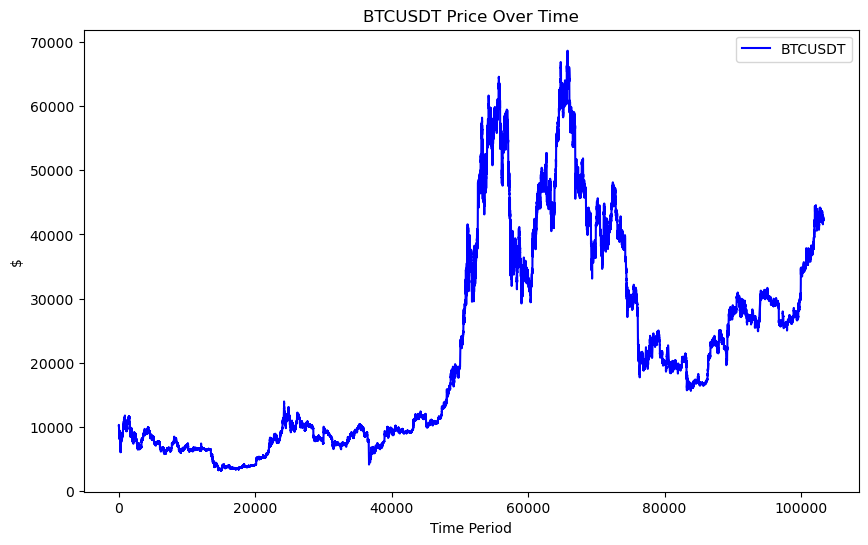

In [4]:
plt.figure(figsize=(10, 6))
plt.plot(btc_close, label="BTCUSDT", color="blue")
plt.xlabel("Time Period")
plt.ylabel("$")
plt.title("BTCUSDT Price Over Time")
plt.legend()
plt.grid(False)
plt.show()

In [5]:
# Step 3: Update the sequence creation function to use unscaled percentage changes and scaled volumes
def create_windowed_sequences(data, window_size, forecast_horizon=5):
    sequences = []
    targets = []
    data_array = data[['open_return', 'high_return', 'low_return', 'close_return', 'normalized_dollar_volume', 'fear_index_normalized']].values
    for i in range(len(data_array) - window_size - forecast_horizon + 1):
        sequence = data_array[i:i+window_size]
        target = data_array[i + window_size:i + window_size + forecast_horizon]
        sequences.append(sequence)
        targets.append(target)
    return np.array(sequences), np.array(targets)

def create_windowed_sequences_levels(data, window_size, forecast_horizon=5):
    sequences = []
    targets = []
    data_array = data[['open', 'high', 'low', 'close', 'normalized_dollar_volume', 'fear_index_normalized']].values
    for i in range(len(data_array) - window_size - forecast_horizon + 1):
        sequence = data_array[i:i+window_size]
        target = data_array[i + window_size:i + window_size + forecast_horizon]
        sequences.append(sequence)
        targets.append(target)
    return np.array(sequences), np.array(targets)

In [6]:
def window_series_multivariate(series_df, input_window=100, forecast_window=30, n_windows0=10000):
    n_periods = series_df.shape[0]
    n_features = series_df.shape[1]
    window_length = input_window + forecast_window
    n_windows = min(n_periods - window_length + 1, n_windows0)
    
    # Initialize the window array for multivariate series
    window_array = np.zeros((window_length, n_windows, n_features))
    
    for w in range(n_windows):
        window = series_df.iloc[w:(w + window_length)].values
        window_array[:, w, :] = window

    # Separate into input and forecast data
    input_data = window_array[0:input_window, :, :]
    forecast_data = window_array[input_window:, :, :]
    
    return input_data, forecast_data

In [7]:
# Set parameters
window_size = 1*24*2*20 # per-hour*hours-per-day*days
forecast_horizon = 1*24*2 # 1 day

variables = ['open_return', 'high_return', 'low_return', 'close_return', 'normalized_dollar_volume', 'fear_index_normalized']
variables_levels = ['open', 'high', 'low', 'close', 'normalized_dollar_volume', 'fear_index_normalized']
df_model = df[variables]
df_model_levels = df[variables_levels]
print("Getting X, y")
X, y = create_windowed_sequences(df_model, window_size, forecast_horizon = forecast_horizon)
print("Getting X_prices, y_prices")
X_prices, y_prices = create_windowed_sequences_levels(df_model_levels, window_size, forecast_horizon = forecast_horizon)

#X_pm, y_pm = window_series_multivariate(df_model, window_size, forecast_window = forecast_horizon, n_windows0 = 160000)


Getting X, y
Getting X_prices, y_prices


In [8]:
print(df_model.shape)
print(X.shape)
print(y.shape)
#print(X_pm.shape)
#print(y_pm.shape)
print(X_prices.shape)
print(y_prices.shape)

(103273, 6)
(102266, 960, 6)
(102266, 48, 6)
(102266, 960, 6)
(102266, 48, 6)


In [9]:
def run_arima_windows_univariate(data_train, data_forecast_actuals, p=0, d=0, q=0, trend=None, horizon=30):
    """
    Function to run ARIMA model on a univariate time series data window.
    If p = d = q = 0, forecasts are based on a random walk without drift.

    Parameters:
    - data_train: 2D numpy array, shape (input_window, n_windows) for the training data windows.
    - data_forecast_actuals: 2D numpy array, shape (forecast_window, n_windows) for the actual future data.
    - p, d, q: ARIMA model order parameters.
    - trend: Trend parameter for ARIMA model. For a random walk with drift, use 'c' (constant).
    - horizon: Forecast horizon, i.e., number of steps to forecast.

    Returns:
    - forecast_matrix: 2D numpy array with forecasts, shape (horizon, n_windows).
    - model_accuracy_table: DataFrame with accuracy metrics for each horizon step.
    """
    n_windows = data_train.shape[0]
    
    # Initialize forecast and error matrices
    forecast_matrix = np.full((horizon, n_windows), np.nan)
    error_matrix = np.full((horizon, n_windows), np.nan)
    
    if p == 0 and d == 0 and q == 0 and trend == None:
        # If p=d=q=0, we have a random walk (no drift).
        # Simply predict the last value in each training window for all forecast steps.
        forecast_matrix[:] = 0  # Set all forecast steps to 0 growth in RW no Drift
    else:
        # Run ARIMA model for each window
        for w in range(n_windows):
            model = ARIMA(data_train[w, :], order=(p, d, q), trend=trend)
            model_fit = model.fit()
            forecast = model_fit.forecast(steps=horizon)
            forecast_matrix[:, w] = forecast
            if w % 20 == 0:
                print(f"Window: {w} / {n_windows}")

    # Compute errors
    data_forecast_actuals_transpose = data_forecast_actuals.T
    error_matrix = forecast_matrix - data_forecast_actuals_transpose
    


    # Calculate accuracy metrics
    accuracy_matrix = np.zeros((6, horizon))

    for h in range(horizon):
        # Errors at step h
        horizon_errors = error_matrix[h, :]
        actuals_at_horizon = data_forecast_actuals_transpose[h, :]
        
        # Compute accuracy metrics for the unnormalized errors
        accuracy_matrix[0, h] = np.sqrt(np.mean(horizon_errors**2))  # RMSE
        accuracy_matrix[1, h] = np.mean(horizon_errors**2)  # MSE
        accuracy_matrix[2, h] = np.mean(horizon_errors)  # ME
        accuracy_matrix[3, h] = np.mean(np.abs(horizon_errors / (actuals_at_horizon + 1e-8)))  # MAPE
        accuracy_matrix[4, h] = np.mean(horizon_errors / (actuals_at_horizon + 1e-8))  # MPE

        ss_res = np.sum(horizon_errors**2)  # Residual sum of squares
        ss_tot = np.sum((actuals_at_horizon - np.mean(actuals_at_horizon))**2)  # Total sum of squares
        r_squared = 1 - (ss_res / ss_tot) if ss_tot != 0 else 0  # Handle edge case where ss_tot = 0
        accuracy_matrix[5, h] = r_squared

    # Create DataFrame for accuracy table
    model_accuracy_table = pd.DataFrame(
        accuracy_matrix.T, columns=["RMSE", "MSE", "ME", "MAPE", "MPE", "R^2"]
    )

    return forecast_matrix, model_accuracy_table

In [10]:
# Calculate exact split sizes
train_ratio, valid_ratio, test_ratio = 0.7, 0.15, 0.15
total_size = len(X)

In [11]:
# First, calculate training and validation sizes
train_size = int(total_size * train_ratio)
valid_size = int(total_size * valid_ratio)
test_size = total_size - (train_size + valid_size)  # Assign remaining data to test to ensure total matches


In [12]:
# Apply the split
X_train, y_train = X[:train_size], y[:train_size]
X_valid, y_valid = X[train_size:train_size + valid_size], y[train_size:train_size + valid_size]
X_test, y_test = X[train_size + valid_size:], y[train_size + valid_size:]

X_train_prices, y_train_prices = X_prices[:train_size], y_prices[:train_size]
X_valid_prices, y_valid_prices = X_prices[train_size:train_size + valid_size], y_prices[train_size:train_size + valid_size]
X_test_prices, y_test_prices = X_prices[train_size + valid_size:], y_prices[train_size + valid_size:]


In [13]:
combined_length = len(X_train) + len(X_valid) + len(X_test)
print(combined_length)
print(X_train.shape)
print(X_valid.shape)
print(X_test.shape)
print(X_test[:,:,3].shape)
print(y_test[:,:,3].shape)

102266
(71586, 960, 6)
(15339, 960, 6)
(15341, 960, 6)
(15341, 960)
(15341, 48)


In [14]:
forecast_matrix_RW_test, model_accuracy_table_RW_test = run_arima_windows_univariate(X_test[:,:,3],
                                                                              y_test[:,:,3],
                                                                              p=0, d=0, q=0,
                                                                              trend = None,
                                                                              horizon=forecast_horizon)
forecast_matrix_RW_valid, model_accuracy_table_RW_valid = run_arima_windows_univariate(X_valid[:,:,3],
                                                                              y_valid[:,:,3],
                                                                              p=0, d=0, q=0,
                                                                              trend = None,
                                                                              horizon=forecast_horizon)

In [15]:
print(model_accuracy_table_RW_test)
print(forecast_matrix_RW_test)

model_accuracy_table_RW_test.to_csv('model_accuracy_table_RW_test.csv', index=False)
np.save('forecast_matrix_RW_test.npy', forecast_matrix_RW_test)

model_accuracy_table_RW_test = pd.read_csv('model_accuracy_table_RW_test.csv', na_values=["inf", "NaN"])
forecast_matrix_RW_test = np.load('forecast_matrix_RW_test.npy')
print(model_accuracy_table_RW_test)
print(forecast_matrix_RW_test)



        RMSE      MSE        ME      MAPE       MPE       R^2
0   0.003211  0.00001 -0.000048  0.999472 -0.999472 -0.000227
1   0.003211  0.00001 -0.000049  0.999472 -0.999472 -0.000230
2   0.003211  0.00001 -0.000049  0.999472 -0.999472 -0.000230
3   0.003211  0.00001 -0.000048  0.999472 -0.999472 -0.000227
4   0.003211  0.00001 -0.000048  0.999472 -0.999472 -0.000225
5   0.003211  0.00001 -0.000048  0.999472 -0.999472 -0.000223
6   0.003211  0.00001 -0.000048  0.999472 -0.999472 -0.000223
7   0.003211  0.00001 -0.000048  0.999472 -0.999472 -0.000225
8   0.003211  0.00001 -0.000048  0.999472 -0.999472 -0.000226
9   0.003211  0.00001 -0.000048  0.999472 -0.999472 -0.000225
10  0.003211  0.00001 -0.000048  0.999472 -0.999472 -0.000224
11  0.003211  0.00001 -0.000048  0.999472 -0.999472 -0.000224
12  0.003211  0.00001 -0.000048  0.999472 -0.999472 -0.000228
13  0.003211  0.00001 -0.000049  0.999472 -0.999472 -0.000232
14  0.003202  0.00001 -0.000047  0.999472 -0.999472 -0.000219
15  0.00

In [16]:
# Convert data to PyTorch tensors
X_train = torch.tensor(X_train, dtype=torch.float32).to(device)
y_train = torch.tensor(y_train, dtype=torch.float32).to(device)
X_valid = torch.tensor(X_valid, dtype=torch.float32).to(device)
y_valid = torch.tensor(y_valid, dtype=torch.float32).to(device)
X_test = torch.tensor(X_test, dtype=torch.float32).to(device)
y_test = torch.tensor(y_test, dtype=torch.float32).to(device)



In [17]:
# Define the LSTM model in PyTorch
class LSTMModel(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim, num_layers,dropout_rate):
        super(LSTMModel, self).__init__()
        self.lstm = nn.LSTM(input_dim, hidden_dim, num_layers, batch_first=True)
        self.dropout = nn.Dropout(dropout_rate)
        self.fc = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        lstm_out, _ = self.lstm(x)
        lstm_out = self.dropout(lstm_out)
        x = self.fc(lstm_out[:, -1, :])
        return x.view(-1, forecast_horizon, input_dim)

In [18]:
# Hyperparameters
input_dim = 6
hidden_dim = 200
num_layers = 1
output_dim = forecast_horizon * 6
num_epochs = 100
batch_size = 20 # 32
learning_rate = 0.0001 # 0.001
dropout_rate = 0.2
patience = 5

# Initialize model, loss function, and optimizer
model = LSTMModel(input_dim, hidden_dim, output_dim, num_layers, dropout_rate).to(device)
criterion = nn.SmoothL1Loss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

# Prepare DataLoader for training
train_data = TensorDataset(X_train, y_train)
train_loader = DataLoader(train_data, shuffle=True, batch_size=batch_size)

# Training loop with early stopping
best_val_loss = float('inf')
epochs_no_improve = 0

In [ ]:
class CombinedLoss(nn.Module):
    def __init__(self, gamma=0.9, beta=1.0, beta_v=1.0, alpha=0.1, lambda_d=1.0, lambda_v=1.0, lambda_dir=1.0):
        """
        Combined loss function with decoupled parameters for baseline and volatility losses.
        Args:
            gamma (float): Discount rate for near-term accuracy in DiscountedSmoothL1Loss.
            beta (float): Smooth L1 Loss transition point for baseline loss.
            beta_v (float): Smooth L1 Loss transition point for volatility loss.
            alpha (float): Weight for directional accuracy in DirectionalLoss.
            lambda_d (float): Weight for baseline loss (DiscountedSmoothL1Loss).
            lambda_v (float): Weight for volatility loss (decoupled volatility penalty).
            lambda_dir (float): Weight for directional accuracy loss (DirectionalLoss).
        """
        super(CombinedLoss, self).__init__()
        self.gamma = gamma
        self.beta = beta  # For baseline loss
        self.beta_v = beta_v  # For volatility loss
        self.alpha = alpha
        self.lambda_d = lambda_d
        self.lambda_v = lambda_v
        self.lambda_dir = lambda_dir

    def forward(self, predictions, targets, historical_prices):
        """
        Compute the combined loss.
        Args:
            predictions: Predicted values (e.g., future prices).
            targets: Actual future values (ground truth).
            historical_prices: Current prices (to determine volatility and directions).
        Returns:
            torch.Tensor: Combined loss.
        """
        horizon = predictions.size(1)  # Assumes shape (batch_size, horizon, ...)
        historical_prices = historical_prices.unsqueeze(1).expand_as(predictions)
        
        # -------------------------------
        # Baseline Loss: DiscountedSmoothL1Loss
        # -------------------------------
        diff = torch.abs(predictions - targets)

        # Smooth L1 Loss with quadratic behavior for small errors, linear for large errors
        base_loss = torch.where(
            diff < self.beta,  # Use baseline `beta`
            0.5 * (diff ** 2) / self.beta,
            diff - 0.5 * self.beta
        )

        # Apply discount factors
        discount_factors = torch.tensor([self.gamma ** (h - 1) for h in range(1, horizon + 1)], device=predictions.device)
        discount_factors = discount_factors.view(1, -1, *(1,) * (base_loss.ndim - 2))  # Broadcast
        discounted_loss = base_loss * discount_factors

        baseline_loss = discounted_loss.mean()  # Average over all dimensions

        # -------------------------------
        # Directional Accuracy Loss
        # -------------------------------
        # Compute directional accuracy
        predicted_directions = torch.sign(predictions)
        actual_directions = torch.sign(targets)
        directional_accuracy = (predicted_directions == actual_directions).float().mean()

        # Penalize incorrect directions
        directional_loss = self.alpha * (1 - directional_accuracy)

        # -------------------------------
        # Combined Loss
        # -------------------------------
        combined_loss = (
            self.lambda_d * baseline_loss +       # Baseline loss
            self.lambda_dir * directional_loss   # Directional accuracy penalty
        )

        return combined_loss

# Experiment with different loss configurations
loss_configs = [
    {"gamma": 1, "beta": 1, "beta_v": 1, "alpha": 0.1, "lambda_v": 0, "lambda_dir": 0},  # Basic Loss
    # {"gamma": 1, "beta": 1, "beta_v": 1.2, "alpha": 0.1, "lambda_v": 0.5, "lambda_dir": 0},
    # {"gamma": 1, "beta": 1, "beta_v": 1.5, "alpha": 0.1, "lambda_v": 1, "lambda_dir": 0},
    # {"gamma": 1, "beta": 1, "beta_v": 2, "alpha": 0.1, "lambda_v": 1.5, "lambda_dir": 0},
    {"gamma": 1, "beta": 1, "beta_v": 1, "alpha": 1.2, "lambda_v": 0, "lambda_dir": 0.5},
    {"gamma": 1, "beta": 1, "beta_v": 1, "alpha": 1.5, "lambda_v": 0, "lambda_dir": 1},
    # {"gamma": 1, "beta": 1, "beta_v": 1, "alpha": 2, "lambda_v": 0, "lambda_dir": 1.5},
    # {"gamma": 1, "beta": 1, "beta_v": 1.2, "alpha": 1.2, "lambda_v": 0.5, "lambda_dir": 0.5},
    # {"gamma": 1, "beta": 1, "beta_v": 1.2, "alpha": 1.5, "lambda_v": 1, "lambda_dir": 1},
    # {"gamma": 1, "beta": 1, "beta_v": 1.5, "alpha": 1.2, "lambda_v": 1, "lambda_dir": 1},
    # {"gamma": 1, "beta": 1, "beta_v": 2, "alpha": 2, "lambda_v": 1.5, "lambda_dir": 1.5},
]

# Training loop with early stopping
best_val_loss = float('inf')
epochs_no_improve = 0

# Hyperparameters
input_dim = 6 #<--- Dont change this
# hidden_dim = [20, 20, 20, 50, 50, 50, 50, 50, 50] # round 1
hidden_dim = [20] # best round 1
# hidden_dim = [64, 64, 64, 128, 128, 128, 256, 256, 256, 512, 512, 512] # round 2
# hidden_dim = [64] # best round 2
# num_layers = [1, 1, 1, 1, 1, 1, 2, 2, 2] # round 1
num_layers = [1] # best round 1
# num_layers = [1, 1, 2, 1, 1, 2, 1, 1, 2, 1, 1, 2] # round 2
# num_layers = [1] # best round 2
output_dim = forecast_horizon * 6 #<--- Dont change this
num_epochs = 100 #<--- Dont change this
# batch_size = [128, 128, 128, 128, 128, 128, 128, 128, 128] # round 1
batch_size = [128] # best round 1
# batch_size = [64, 64, 128, 64, 64, 128, 64, 64, 128, 64, 64, 128] # round 2
# batch_size = [64] # best round 2
learning_rate = 0.0001 # 0.001
# dropout_rate = [0.2, 0.2, 0.2, 0.3, 0.3, 0.3, 0.3, 0.3, 0.3] # round 1
dropout_rate = [0.2] # best round 1
# dropout_rate = [0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2] # round 2
# dropout_rate = [0.2] # best round 2
patience = 10 #<--- Dont change this
# GAMMA = [1, 0.8, 0.65, 1, 0.8, 0.65, 1, 0.8, 0.65] # round 1
# GAMMA = [1] # best round 1
# GAMMA = [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1] # round 2
# GAMMA = [1] # best round 2

n_alternatives = len(hidden_dim)

train_losses_master = []
train_losses_close_master = []
val_losses_master = []
val_losses_close_master = []
best_model_state_master = []
best_model_state_close_master = []
hyperparameter_results = []

    
for config_idx, loss_config in enumerate(loss_configs):
    alt = 0
    print(f"Running Configuration {config_idx + 1}: {loss_config}")
    
    # Initialize model, loss function, and optimizer
    model = LSTMModel(input_dim, hidden_dim[alt], output_dim, num_layers[alt], dropout_rate[alt]).to(device)
    training_criterion = CombinedLoss(
        gamma=loss_config["gamma"],
        beta=loss_config["beta"],
        beta_v=loss_config["beta_v"],
        alpha=loss_config["alpha"],
        lambda_v=loss_config["lambda_v"],
        lambda_dir=loss_config["lambda_dir"]
    )
    valid_criterion = nn.SmoothL1Loss()
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

    # Prepare DataLoader for training
    train_data = TensorDataset(X_train, y_train)
    train_loader = DataLoader(train_data, shuffle=True, batch_size=batch_size[alt])
    
    val_data = TensorDataset(X_valid, y_valid)   #
    val_loader = DataLoader(val_data, shuffle=False, batch_size=batch_size[alt], )  #

    # Training loop with early stopping
    best_val_loss = float('inf')
    best_val_loss_close = float('inf')
    epochs_no_improve = 0

    # Create Lists to Track Error Across Epochs
    train_losses = []
    train_losses_close = []
    val_losses = []
    val_losses_close = []


    for epoch in range(num_epochs):
        model.train()
        epoch_train_loss = 0
        epoch_train_loss_close = 0

        for inputs, targets in train_loader:
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = model(inputs)
            loss = training_criterion(outputs, targets, inputs[:, -1, :])
            loss_close = valid_criterion(outputs[:,:,3], targets[:,:,3]) # Not a typo - I want comparable training loss and its only the gradient descent I want the discounted criterion
            epoch_train_loss += loss.item()
            epoch_train_loss_close += loss_close.item()

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

        avg_train_loss = epoch_train_loss / len(train_loader)
        train_losses.append(avg_train_loss)
        avg_train_loss_close = epoch_train_loss_close / len(train_loader)
        train_losses_close.append(avg_train_loss_close)

        # Validation Loss
        model.eval()
        epoch_val_loss = 0
        epoch_val_loss_close = 0
        with torch.no_grad():
            for val_inputs, val_targets in val_loader:
                
                val_inputs, val_targets = val_inputs.to(device), val_targets.to(device)
                val_outputs = model(val_inputs)
                val_loss = valid_criterion(val_outputs, val_targets)
                val_loss_close = valid_criterion(val_outputs[:,:,3], val_targets[:,:,3])
                epoch_val_loss += val_loss.item()
                epoch_val_loss_close += val_loss_close.item()
                
                #val_outputs = model(X_valid.to(device))
                #val_loss = criterion(val_outputs, y_valid.to(device))
                #val_losses.append(val_loss.item())
                #val_loss_close = criterion(val_outputs[:,:,3], y_valid[:,:,3].to(device))
                #val_losses_close.append(val_loss_close.item())
                
        avg_val_loss = epoch_val_loss / len(val_loader)
        val_losses.append(avg_val_loss)
        avg_val_loss_close = epoch_val_loss_close / len(val_loader)
        val_losses_close.append(avg_val_loss_close)


        print(f"Epoch [{epoch+1}/{num_epochs}], "
          f"Training Loss: {avg_train_loss:.10f}, "
          f"Validation Loss: {avg_val_loss:.10f}, "
          #f"Training Loss (Close): {avg_train_loss_close:.10f}, "
          f"Validation Loss (Close): {avg_val_loss_close:.10f}")


        # Check for improvement
        if avg_val_loss < best_val_loss:
            best_val_loss = avg_val_loss
            epochs_no_improve = 0
            best_model_state = model.state_dict()
        else:
            epochs_no_improve += 1
            
        if avg_val_loss_close < best_val_loss_close:
            best_val_loss_close = avg_val_loss_close
            epochs_no_improve_close = 0
            best_model_state_close = model.state_dict()
        else:
            epochs_no_improve_close += 1

        #if epochs_no_improve >= patience:
        #    print(f"Early stopping triggered after {epoch+1} epochs.")
        #    break
            
        if epochs_no_improve_close >= patience:
            print(f"Early stopping triggered after {epoch+1} epochs (Based on Closing Price Returns).")
            break
            
    train_losses_master.append(train_losses)
    train_losses_close_master.append(train_losses_close)
    val_losses_master.append(val_losses)
    val_losses_close_master.append(val_losses_close)
    best_model_state_master.append(best_model_state.copy())
    
    result = {
        "hidden_dim": hidden_dim[alt],
        "num_layers": num_layers[alt],
        "batch_size": batch_size[alt],
        "dropout_rate": dropout_rate[alt],
        "best_val_loss": best_val_loss,
        "best_val_loss_close": best_val_loss_close,
        "train_losses": train_losses,
        "val_losses": val_losses,
        "train_losses_close": train_losses_close,
        "val_losses_close": val_losses_close,
        "best_model_state": best_model_state,
        "best_model_state_close": best_model_state_close,
        "loss_config": loss_config
    }
    hyperparameter_results.append(result)


Running Configuration 1: {'gamma': 1, 'beta': 1, 'beta_v': 1, 'alpha': 0.1, 'lambda_v': 0, 'lambda_dir': 0}
Epoch [1/100], Training Loss: 0.1000179959, Validation Loss: 0.0521579419, Validation Loss (Close): 0.0004141515
Epoch [2/100], Training Loss: 0.0530671171, Validation Loss: 0.0446430961, Validation Loss (Close): 0.0005442385
Epoch [3/100], Training Loss: 0.0476239415, Validation Loss: 0.0438431540, Validation Loss (Close): 0.0004126384
Epoch [4/100], Training Loss: 0.0456011693, Validation Loss: 0.0426047841, Validation Loss (Close): 0.0002820044
Epoch [5/100], Training Loss: 0.0436908116, Validation Loss: 0.0401837285, Validation Loss (Close): 0.0001438772
Epoch [6/100], Training Loss: 0.0422215250, Validation Loss: 0.0389591125, Validation Loss (Close): 0.0000975929
Epoch [7/100], Training Loss: 0.0414077379, Validation Loss: 0.0381876030, Validation Loss (Close): 0.0000613785
Epoch [8/100], Training Loss: 0.0407707154, Validation Loss: 0.0376014850, Validation Loss (Close): 0

Epoch [29/100], Training Loss: 0.0084664962, Validation Loss: 0.0406226250, Validation Loss (Close): 0.0000116410
Epoch [30/100], Training Loss: 0.0084404032, Validation Loss: 0.0405503722, Validation Loss (Close): 0.0000116617
Epoch [31/100], Training Loss: 0.0084174727, Validation Loss: 0.0406249413, Validation Loss (Close): 0.0000116837
Epoch [32/100], Training Loss: 0.0084126905, Validation Loss: 0.0405882861, Validation Loss (Close): 0.0000117098
Epoch [33/100], Training Loss: 0.0084195335, Validation Loss: 0.0405392092, Validation Loss (Close): 0.0000117027
Epoch [34/100], Training Loss: 0.0084077120, Validation Loss: 0.0406387586, Validation Loss (Close): 0.0000116756
Epoch [35/100], Training Loss: 0.0083864953, Validation Loss: 0.0405216352, Validation Loss (Close): 0.0000116855
Epoch [36/100], Training Loss: 0.0084090112, Validation Loss: 0.0404508016, Validation Loss (Close): 0.0000116868
Epoch [37/100], Training Loss: 0.0084001327, Validation Loss: 0.0407398766, Validation L

Epoch [63/100], Training Loss: 0.0044791186, Validation Loss: 0.0401897299, Validation Loss (Close): 0.0000121261
Epoch [64/100], Training Loss: 0.0044929383, Validation Loss: 0.0402336973, Validation Loss (Close): 0.0000121486
Epoch [65/100], Training Loss: 0.0044909532, Validation Loss: 0.0402274834, Validation Loss (Close): 0.0000121358
Epoch [66/100], Training Loss: 0.0044804832, Validation Loss: 0.0401448889, Validation Loss (Close): 0.0000120847
Epoch [67/100], Training Loss: 0.0044834207, Validation Loss: 0.0401999396, Validation Loss (Close): 0.0000120849
Epoch [68/100], Training Loss: 0.0044782657, Validation Loss: 0.0402198365, Validation Loss (Close): 0.0000120844
Epoch [69/100], Training Loss: 0.0044742386, Validation Loss: 0.0405033364, Validation Loss (Close): 0.0000120777
Epoch [70/100], Training Loss: 0.0044705636, Validation Loss: 0.0404127421, Validation Loss (Close): 0.0000120813
Epoch [71/100], Training Loss: 0.0044721808, Validation Loss: 0.0402086270, Validation L

Epoch [1/100], Training Loss: 0.0186755689, Validation Loss: 0.0453100341, Validation Loss (Close): 0.0002914669
Epoch [2/100], Training Loss: 0.0102957391, Validation Loss: 0.0415263385, Validation Loss (Close): 0.0001469553
Epoch [3/100], Training Loss: 0.0095198276, Validation Loss: 0.0411378172, Validation Loss (Close): 0.0000849882
Epoch [4/100], Training Loss: 0.0091674215, Validation Loss: 0.0410379030, Validation Loss (Close): 0.0000541990
Epoch [5/100], Training Loss: 0.0089437786, Validation Loss: 0.0408783587, Validation Loss (Close): 0.0000500501
Epoch [6/100], Training Loss: 0.0088099418, Validation Loss: 0.0408579902, Validation Loss (Close): 0.0000442812
Epoch [7/100], Training Loss: 0.0087138040, Validation Loss: 0.0408055791, Validation Loss (Close): 0.0000425330
Epoch [8/100], Training Loss: 0.0086324116, Validation Loss: 0.0408860783, Validation Loss (Close): 0.0000286694
Epoch [9/100], Training Loss: 0.0085846200, Validation Loss: 0.0408880539, Validation Loss (Clos

Epoch [39/100], Training Loss: 0.0044674397, Validation Loss: 0.0396626758, Validation Loss (Close): 0.0000139801
Epoch [40/100], Training Loss: 0.0044470350, Validation Loss: 0.0394098187, Validation Loss (Close): 0.0000146176
Epoch [41/100], Training Loss: 0.0044437562, Validation Loss: 0.0392927357, Validation Loss (Close): 0.0000147864
Epoch [42/100], Training Loss: 0.0044341869, Validation Loss: 0.0391792190, Validation Loss (Close): 0.0000153236
Epoch [43/100], Training Loss: 0.0044279163, Validation Loss: 0.0389119149, Validation Loss (Close): 0.0000152143
Epoch [44/100], Training Loss: 0.0044196615, Validation Loss: 0.0388461923, Validation Loss (Close): 0.0000147996
Early stopping triggered after 44 epochs (Based on Closing Price Returns).
Hyperparameter Alternative: [7/9], Hidden Dimensions: 50, Number of Layers: 2, Batch Size: 128, Dropout Rate: 0.3, Gamma: 1
Epoch [1/100], Training Loss: 0.0884727316, Validation Loss: 0.0421774807, Validation Loss (Close): 0.0002271604
Epoc

Epoch [32/100], Training Loss: 0.0080556833, Validation Loss: 0.0374877681, Validation Loss (Close): 0.0000117303
Epoch [33/100], Training Loss: 0.0080485560, Validation Loss: 0.0377267545, Validation Loss (Close): 0.0000117533
Epoch [34/100], Training Loss: 0.0080385460, Validation Loss: 0.0377923945, Validation Loss (Close): 0.0000117011
Epoch [35/100], Training Loss: 0.0080437611, Validation Loss: 0.0378365835, Validation Loss (Close): 0.0000117851
Epoch [36/100], Training Loss: 0.0080321507, Validation Loss: 0.0377746541, Validation Loss (Close): 0.0000117492
Epoch [37/100], Training Loss: 0.0080229542, Validation Loss: 0.0376197323, Validation Loss (Close): 0.0000117543
Epoch [38/100], Training Loss: 0.0079913629, Validation Loss: 0.0374571298, Validation Loss (Close): 0.0000117377
Early stopping triggered after 38 epochs (Based on Closing Price Returns).
Hyperparameter Alternative: [9/9], Hidden Dimensions: 50, Number of Layers: 2, Batch Size: 128, Dropout Rate: 0.3, Gamma: 0.65


Epoch [65/100], Training Loss: 0.0042820381, Validation Loss: 0.0374300227, Validation Loss (Close): 0.0000118364
Epoch [66/100], Training Loss: 0.0042883569, Validation Loss: 0.0376207457, Validation Loss (Close): 0.0000117641
Epoch [67/100], Training Loss: 0.0042791038, Validation Loss: 0.0376123743, Validation Loss (Close): 0.0000118131
Epoch [68/100], Training Loss: 0.0042808960, Validation Loss: 0.0375183281, Validation Loss (Close): 0.0000118246
Epoch [69/100], Training Loss: 0.0042700071, Validation Loss: 0.0373533612, Validation Loss (Close): 0.0000118120
Epoch [70/100], Training Loss: 0.0042688857, Validation Loss: 0.0372411087, Validation Loss (Close): 0.0000118168
Epoch [71/100], Training Loss: 0.0042734804, Validation Loss: 0.0374448653, Validation Loss (Close): 0.0000118162
Epoch [72/100], Training Loss: 0.0042761388, Validation Loss: 0.0373229660, Validation Loss (Close): 0.0000117747
Epoch [73/100], Training Loss: 0.0042782989, Validation Loss: 0.0377379647, Validation L

In [20]:
save_dir = "../results/"
# Save metadata
results_metadata = [
    {
        "hidden_dim": result["hidden_dim"],
        "num_layers": result["num_layers"],
        "batch_size": result["batch_size"],
        "dropout_rate": result["dropout_rate"],
        "best_val_loss": result["best_val_loss"],
        "best_val_loss_close": result["best_val_loss_close"],
        "loss_config": result["loss_config"]
    }
    for result in hyperparameter_results
]

metadata_path = os.path.join(save_dir, "results_metadata.json")
with open(metadata_path, "w") as f:
    json.dump(results_metadata, f, indent=4)

In [21]:
# Save each model state
for i, result in enumerate(hyperparameter_results):
    model_path = os.path.join(save_dir, f"best_model_state_BTCUSDT_sentiment_{i}.pth")
    torch.save(result["best_model_state"], model_path)

print(f"Metadata saved to {metadata_path}. Model states saved to {save_dir}.")

#for i, result in enumerate(hyperparameter_results):
#    torch.save(result["best_model_state"], f"best_model_state_BTCUSDT_with_gamma_{i}.pth")
#print("Model states saved as best_model_state_BTCUSDT_with_gamma_0.pth, best_model_state_BTCUSDT_with_gamma_1.pth, ...")

Metadata saved to ../results/results_metadata.json. Model states saved to ../results/.


In [22]:
# Load Hyper Parameter Results
with open(metadata_path, "r") as f:
    loaded_metadata = json.load(f)

# Reload models
loaded_results = []
for i, meta in enumerate(loaded_metadata):
    model_path = os.path.join(save_dir, f"best_model_state_BTCUSDT_sentiment_{i}.pth")
    model_state = torch.load(model_path, weights_only=True)

    result = {
        "hidden_dim": meta["hidden_dim"],
        "num_layers": meta["num_layers"],
        "batch_size": meta["batch_size"],
        "dropout_rate": meta["dropout_rate"],
        "best_val_loss": meta["best_val_loss"],
        "best_val_loss_close": meta["best_val_loss_close"],
        "loss_config": meta["loss_config"],
        "best_model_state": model_state
    }
    loaded_results.append(result)

print("Results reloaded successfully!")

Results reloaded successfully!


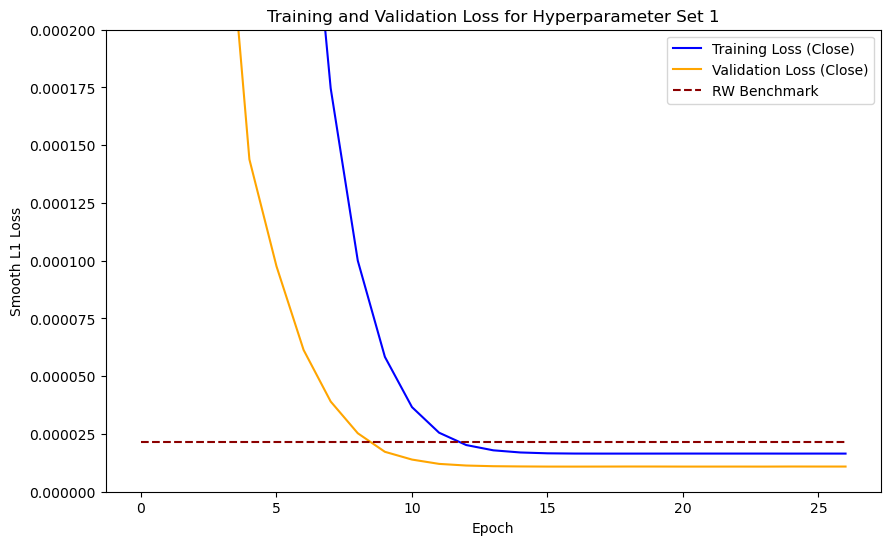

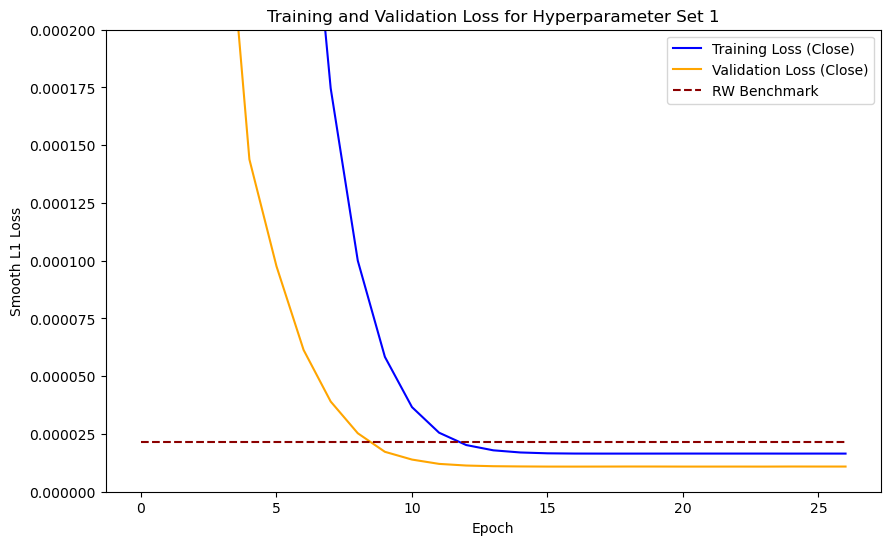

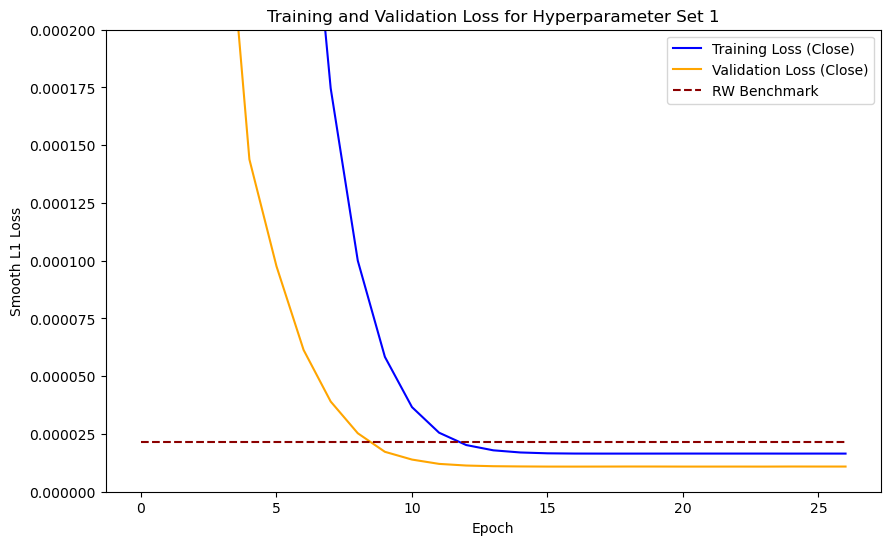

In [23]:
# Plot Performance for Each Hyperparameter Set

#ylim_max = [0.0002,0.0002,0.0002,0.0002,0.0002,0.0002,0.0002,0.0002,0.0002]
ylim_max = 0.0002

for config_idx, loss_config in enumerate(loss_configs):  # Loop over the 6 hyperparameter alternatives
    alt = 0
    train_losses_close = train_losses_close_master[alt]
    val_losses_close = val_losses_close_master[alt]

    # Create RW Benchmark Line for Validation Loss
    RW_benchmark_MSE_valid = model_accuracy_table_RW_valid['MSE'][0]  # Fixed RW Benchmark value
    RW_benchmark_MSE_line = np.full(len(train_losses_close), RW_benchmark_MSE_valid)  # Benchmark line

    # Plot losses and benchmark
    plt.figure(figsize=(10, 6))
    plt.plot(train_losses_close, label='Training Loss (Close)', color='blue')
    plt.plot(val_losses_close, label='Validation Loss (Close)', color='orange')
    plt.plot(RW_benchmark_MSE_line, label='RW Benchmark', color='darkred', linestyle='--')
    
    # Formatting
    plt.title(f"Training and Validation Loss for Hyperparameter Set {alt+1}")
    plt.xlabel("Epoch")
    plt.ylabel("Smooth L1 Loss")
    plt.legend()
    plt.ylim([0, ylim_max])  # Adjust based on your loss range
    plt.grid(False)
    plt.show()


In [24]:
def create_basic_accuracy_table(predictions, actuals):
    
    forecast_horizon = predictions.shape[1]
    accuracy_matrix = np.full((forecast_horizon, 6), np.nan)
    
    horizon_errors = predictions[:,:] - actuals[:,:]

    for h in range(forecast_horizon):

        # Compute accuracy metrics
        accuracy_matrix[h,0] = np.sqrt(np.mean(horizon_errors[:,h]**2))  # RMSE
        accuracy_matrix[h,1] = np.mean(horizon_errors[:,h]**2)  # MSE
        accuracy_matrix[h,2] = np.mean(horizon_errors[:,h])  # ME
        accuracy_matrix[h,3] = np.mean(np.abs(horizon_errors[:,h] / actuals[:,h]))  # MAPE
        accuracy_matrix[h,4] = np.mean(horizon_errors[:,h] / actuals[:,h])  # MPE
        
        ss_res = np.sum(horizon_errors[:,h]**2)  # Residual sum of squares
        ss_tot = np.sum((actuals[:,h] - np.mean(actuals[:,h]))**2)  # Total sum of squares
        r_squared = 1 - (ss_res / ss_tot) if ss_tot != 0 else 0  # Handle edge case where ss_tot = 0
        accuracy_matrix[h, 5] = r_squared
    
    
    accuracy_table = pd.DataFrame(accuracy_matrix,
                                  columns=["RMSE", "MSE", "ME", "MAPE", "MPE", "R2"]) 

    return accuracy_table

def add_directional_accuracy(accuracy_table, inputs_actuals, predictions, targets):
    
    forecast_horizon = accuracy_table.shape[0]
    
    directional_accuracy_horizons = np.full((forecast_horizon,1),np.nan)

    for h in range(forecast_horizon):
        
        if h == 0:
            actual_one_period_change_h = targets[:,h] - inputs_actuals[:,(inputs_actuals.shape[1]-1),3]
            actual_one_period_direction_h = np.sign(actual_one_period_change_h)

            predictions_one_period_change_h = predictions[:,h] - inputs_actuals[:,(inputs_actuals.shape[1]-1),3]
            predictions_one_period_direction_h = np.sign(predictions_one_period_change_h)

            predictions_one_period_direction_match_h = predictions_one_period_direction_h == actual_one_period_direction_h
            predictions_one_period_direction_match_accuracy_h = (np.sum(predictions_one_period_direction_match_h,axis=0)/predictions_one_period_direction_match_h.shape[0])
        
            directional_accuracy_horizons[h,0] = predictions_one_period_direction_match_accuracy_h
            
        if h > 0:
            actual_one_period_change_h = targets[:,h] - targets[:,h-1]
            actual_one_period_direction_h = np.sign(actual_one_period_change_h)

            predictions_one_period_change_h = predictions[:,h] - predictions[:,h-1]
            predictions_one_period_direction_h = np.sign(predictions_one_period_change_h)

            predictions_one_period_direction_match_h = predictions_one_period_direction_h == actual_one_period_direction_h
            predictions_one_period_direction_match_accuracy_h = (np.sum(predictions_one_period_direction_match_h,axis=0)/predictions_one_period_direction_match_h.shape[0])
        
            directional_accuracy_horizons[h,0] = predictions_one_period_direction_match_accuracy_h
    
    directional_accuracy_horizons_output = directional_accuracy_horizons.flatten()
    accuracy_table["Direct. Acc."] = directional_accuracy_horizons_output
    
    return accuracy_table

import os

# Directory to store the results
results_dir = "results_table"

# Create the directory if it does not exist
if not os.path.exists(results_dir):
    os.makedirs(results_dir)

for i, result in enumerate(hyperparameter_results):
    print(f"\nCalculating metrics for Hyperparameter Set {i+1}...")
    
    model = LSTMModel(
        input_dim=input_dim,
        hidden_dim=result["hidden_dim"],
        output_dim=output_dim,
        num_layers=result["num_layers"],
        dropout_rate=result["dropout_rate"]
    ).to(device)

    model.load_state_dict(result["best_model_state"])

    print(f"Loaded the best model with Hidden Dim: {result['hidden_dim']}, "
          f"Num Layers: {result['num_layers']}, "
          f"Batch Size: {result['batch_size']}, "
          f"Validation Loss (Close): {result['best_val_loss_close']:.10f}, "
          f"loss_config: {result['loss_config']}")

    batch_size_predictions = 50

    # Function to make predictions in batches
    def predict_in_batches(model, data, batch_size):
        model.eval()
        predictions = []
        with torch.no_grad():
            for i in range(0, len(data), batch_size):
                batch_data = data[i:i + batch_size].to(device)
                batch_predictions = model(batch_data).cpu().numpy()
                predictions.append(batch_predictions)
                if i % 1000 == 0:
                    print(f"Iteration: {i} / {len(data)}")
        return np.concatenate(predictions, axis=0)

    # Make predictions in batches
    train_predictions = predict_in_batches(model, X_train, batch_size_predictions)
    valid_predictions = predict_in_batches(model, X_valid, batch_size_predictions)
    test_predictions = predict_in_batches(model, X_test, batch_size_predictions)

    # Focus only on 'close' price (index 3)
    train_predictions_close_percent = train_predictions[:, :, 3]
    valid_predictions_close_percent = valid_predictions[:, :, 3]
    test_predictions_close_percent = test_predictions[:, :, 3]
    
    train_predictions_close_prices = np.full((train_predictions_close_percent.shape[0],forecast_horizon),np.nan)
    valid_predictions_close_prices = np.full((valid_predictions_close_percent.shape[0],forecast_horizon),np.nan)
    test_predictions_close_prices = np.full((test_predictions_close_percent.shape[0],forecast_horizon),np.nan)

    #### Creating Model Accuracy Metrics for Comparison to Random Walk Benchmark
    train_actuals_close_prices = y_train_prices[:,:,3]
    valid_actuals_close_prices = y_valid_prices[:,:,3]
    test_actuals_close_prices = y_test_prices[:,:,3]
    
    n_cols = X_train_prices.shape[1]

    for h in range(forecast_horizon):
        if h == 0:
            train_predictions_close_prices[:,h] = X_train_prices[:,(n_cols-1),3] * (1 + train_predictions_close_percent[:,h])
            valid_predictions_close_prices[:,h] = X_valid_prices[:,(n_cols-1),3] * (1 + valid_predictions_close_percent[:,h])
            test_predictions_close_prices[:,h] = X_test_prices[:,(n_cols-1),3] * (1 + test_predictions_close_percent[:,h])
        else:
            train_predictions_close_prices[:,h] = train_predictions_close_prices[:,h-1] * (1 + train_predictions_close_percent[:,h]) 
            valid_predictions_close_prices[:,h] = valid_predictions_close_prices[:,h-1] * (1 + valid_predictions_close_percent[:,h])
            test_predictions_close_prices[:,h] = test_predictions_close_prices[:,h-1] * (1 + test_predictions_close_percent[:,h])


    # Calculating Primary Accuracy Metrics
    model_accuracy_table_train = create_basic_accuracy_table(predictions = train_predictions_close_prices,
                                                                  actuals = train_actuals_close_prices)
    
    model_accuracy_table_valid = create_basic_accuracy_table(predictions = valid_predictions_close_prices,
                                                                  actuals = valid_actuals_close_prices)
    
    model_accuracy_table_test = create_basic_accuracy_table(predictions = test_predictions_close_prices,
                                                                  actuals = test_actuals_close_prices)

    
    # Adding Directional Accuracy
    model_accuracy_table_train = add_directional_accuracy(accuracy_table = model_accuracy_table_train,
                                                         inputs_actuals = X_train_prices, 
                                                         predictions = train_predictions_close_prices, 
                                                         targets = train_actuals_close_prices)
    
    model_accuracy_table_valid = add_directional_accuracy(accuracy_table = model_accuracy_table_valid,
                                                         inputs_actuals = X_valid_prices, 
                                                         predictions = valid_predictions_close_prices, 
                                                         targets = valid_actuals_close_prices)
    
    model_accuracy_table_test = add_directional_accuracy(accuracy_table = model_accuracy_table_test,
                                                         inputs_actuals = X_test_prices, 
                                                         predictions = test_predictions_close_prices, 
                                                         targets = test_actuals_close_prices)

    pd.set_option('display.max_columns', None) 
    pd.set_option('display.width', 200)        
    pd.set_option('display.max_rows', None)

    print(model_accuracy_table_train)
    print(model_accuracy_table_valid)
    print(model_accuracy_table_test)

    # Save results for this hyperparameter setting
    setting_dir = os.path.join(results_dir, f"Sentiment_Setting_{i+1}")
    if not os.path.exists(setting_dir):
        os.makedirs(setting_dir)

    # Save parameters as a text file
    with open(os.path.join(setting_dir, "parameters.txt"), "w") as f:
        f.write(f"Hidden Dim: {result['hidden_dim']}\n")
        f.write(f"Num Layers: {result['num_layers']}\n")
        f.write(f"Batch Size: {result['batch_size']}\n")
        f.write(f"Validation Loss (Close): {result['best_val_loss_close']:.10f}\n")
        f.write(f"Loss Config: {result['loss_config']}\n")

    # Save accuracy tables as CSV files
    model_accuracy_table_train.to_csv(os.path.join(setting_dir, "accuracy_table_train.csv"), index=False)
    model_accuracy_table_valid.to_csv(os.path.join(setting_dir, "accuracy_table_valid.csv"), index=False)
    model_accuracy_table_test.to_csv(os.path.join(setting_dir, "accuracy_table_test.csv"), index=False)

    print(f"Results saved for Setting {i+1} in {setting_dir}")


Calculating metrics for Hyperparameter Set 1...
Loaded the best model with Hidden Dim: 20, Num Layers: 1, Batch Size: 128, Validation Loss (Close): 0.0000108725, loss_config: {'gamma': 1, 'beta': 1, 'beta_v': 1, 'alpha': 0.1, 'lambda_v': 0, 'lambda_dir': 0}
Iteration: 0 / 71586
Iteration: 1000 / 71586
Iteration: 2000 / 71586
Iteration: 3000 / 71586
Iteration: 4000 / 71586
Iteration: 5000 / 71586
Iteration: 6000 / 71586
Iteration: 7000 / 71586
Iteration: 8000 / 71586
Iteration: 9000 / 71586
Iteration: 10000 / 71586
Iteration: 11000 / 71586
Iteration: 12000 / 71586
Iteration: 13000 / 71586
Iteration: 14000 / 71586
Iteration: 15000 / 71586
Iteration: 16000 / 71586
Iteration: 17000 / 71586
Iteration: 18000 / 71586
Iteration: 19000 / 71586
Iteration: 20000 / 71586
Iteration: 21000 / 71586
Iteration: 22000 / 71586
Iteration: 23000 / 71586
Iteration: 24000 / 71586
Iteration: 25000 / 71586
Iteration: 26000 / 71586
Iteration: 27000 / 71586
Iteration: 28000 / 71586
Iteration: 29000 / 71586
Iter

In [25]:
device = torch.device("mps" if torch.backends.mps.is_built() else "cpu")
random.seed(100)
torch.cuda.empty_cache()


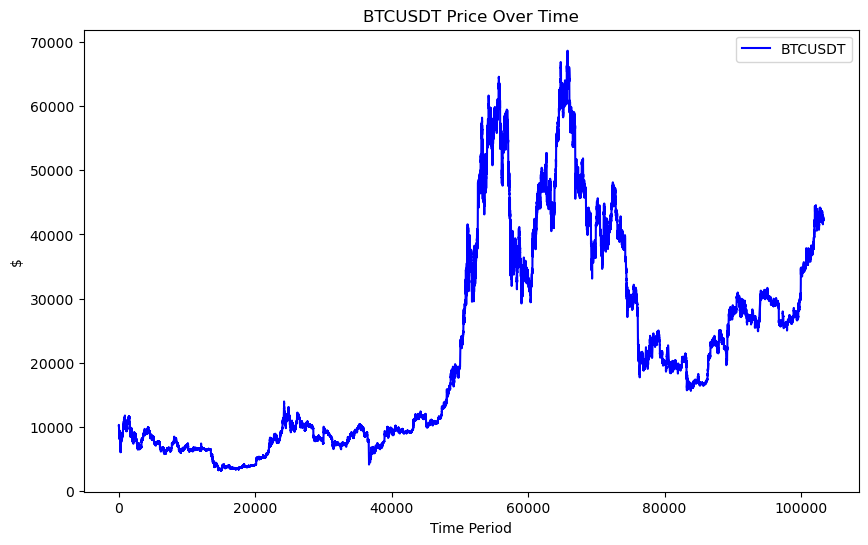

In [26]:
plt.figure(figsize=(10, 6))
plt.plot(btc_close, label="BTCUSDT", color="blue")
plt.xlabel("Time Period")
plt.ylabel("$")
plt.title("BTCUSDT Price Over Time")
plt.legend()
plt.grid(False)
plt.show()

In [27]:
# Set parameters
window_size = 1*24*2*20 # per-hour*hours-per-day*days
forecast_horizon = 1*24*2 # 1 day

variables = ['open_return', 'high_return', 'low_return', 'close_return','normalized_dollar_volume', 'fear_index_normalized']
variables_levels = ['open', 'high', 'low', 'close','normalized_dollar_volume', 'fear_index_normalized']
df_model = df[variables]
df_model_levels = df[variables_levels]
print("Getting X, y")
X, y = create_windowed_sequences(df_model, window_size, forecast_horizon = forecast_horizon)
print("Getting X_prices, y_prices")
X_prices, y_prices = create_windowed_sequences_levels(df_model_levels, window_size, forecast_horizon = forecast_horizon)

# Calculate exact split sizes
train_ratio, valid_ratio, test_ratio = 0.7, 0.15, 0.15
total_size = len(X)

# First, calculate training and validation sizes
train_size = int(total_size * train_ratio)
valid_size = int(total_size * valid_ratio)
test_size = total_size - (train_size + valid_size)  # Assign remaining data to test to ensure total matches

# Apply the split
X_train, y_train = X[:train_size], y[:train_size]
X_valid, y_valid = X[train_size:train_size + valid_size], y[train_size:train_size + valid_size]
X_test, y_test = X[train_size + valid_size:], y[train_size + valid_size:]

X_train_prices, y_train_prices = X_prices[:train_size], y_prices[:train_size]
X_valid_prices, y_valid_prices = X_prices[train_size:train_size + valid_size], y_prices[train_size:train_size + valid_size]
X_test_prices, y_test_prices = X_prices[train_size + valid_size:], y_prices[train_size + valid_size:]

Getting X, y
Getting X_prices, y_prices


In [28]:
forecast_matrix_RW_test, model_accuracy_table_RW_test = run_arima_windows_univariate(X_test[:,:,3],
                                                                              y_test[:,:,3],
                                                                              p=0, d=0, q=0,
                                                                              trend = None,
                                                                              horizon=forecast_horizon)
forecast_matrix_RW_valid, model_accuracy_table_RW_valid = run_arima_windows_univariate(X_valid[:,:,3],
                                                                              y_valid[:,:,3],
                                                                              p=0, d=0, q=0,
                                                                              trend = None,
                                                                              horizon=forecast_horizon)

print(model_accuracy_table_RW_test)
print(forecast_matrix_RW_test)

model_accuracy_table_RW_test.to_csv('model_accuracy_table_RW_test.csv', index=False)
np.save('forecast_matrix_RW_test.npy', forecast_matrix_RW_test)

model_accuracy_table_RW_test = pd.read_csv('model_accuracy_table_RW_test.csv', na_values=["inf", "NaN"])
forecast_matrix_RW_test = np.load('forecast_matrix_RW_test.npy')
print(model_accuracy_table_RW_test)
print(forecast_matrix_RW_test)


        RMSE      MSE        ME      MAPE       MPE       R^2
0   0.003211  0.00001 -0.000048  0.999472 -0.999472 -0.000227
1   0.003211  0.00001 -0.000049  0.999472 -0.999472 -0.000230
2   0.003211  0.00001 -0.000049  0.999472 -0.999472 -0.000230
3   0.003211  0.00001 -0.000048  0.999472 -0.999472 -0.000227
4   0.003211  0.00001 -0.000048  0.999472 -0.999472 -0.000225
5   0.003211  0.00001 -0.000048  0.999472 -0.999472 -0.000223
6   0.003211  0.00001 -0.000048  0.999472 -0.999472 -0.000223
7   0.003211  0.00001 -0.000048  0.999472 -0.999472 -0.000225
8   0.003211  0.00001 -0.000048  0.999472 -0.999472 -0.000226
9   0.003211  0.00001 -0.000048  0.999472 -0.999472 -0.000225
10  0.003211  0.00001 -0.000048  0.999472 -0.999472 -0.000224
11  0.003211  0.00001 -0.000048  0.999472 -0.999472 -0.000224
12  0.003211  0.00001 -0.000048  0.999472 -0.999472 -0.000228
13  0.003211  0.00001 -0.000049  0.999472 -0.999472 -0.000232
14  0.003202  0.00001 -0.000047  0.999472 -0.999472 -0.000219
15  0.00

In [29]:
# Convert data to PyTorch tensors
X_train = torch.tensor(X_train, dtype=torch.float32).to(device)
y_train = torch.tensor(y_train, dtype=torch.float32).to(device)
X_valid = torch.tensor(X_valid, dtype=torch.float32).to(device)
y_valid = torch.tensor(y_valid, dtype=torch.float32).to(device)
X_test = torch.tensor(X_test, dtype=torch.float32).to(device)
y_test = torch.tensor(y_test, dtype=torch.float32).to(device)

In [30]:
# Hyperparameters
input_dim = 6
hidden_dim = 200
num_layers = 1
output_dim = forecast_horizon * 6
num_epochs = 100
batch_size = 20 # 32
learning_rate = 0.0001 # 0.001
dropout_rate = 0.2
patience = 5

# Initialize model, loss function, and optimizer
model = LSTMModel(input_dim, hidden_dim, output_dim, num_layers, dropout_rate).to(device)
criterion = nn.SmoothL1Loss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

# Prepare DataLoader for training
train_data = TensorDataset(X_train, y_train)
train_loader = DataLoader(train_data, shuffle=True, batch_size=batch_size)

# Training loop with early stopping
best_val_loss = float('inf')
epochs_no_improve = 0

In [31]:
class CombinedLoss(nn.Module):
    def __init__(self, gamma=0.9, beta=1.0, beta_v=1.0, alpha=0.1, lambda_d=1.0, lambda_v=1.0, lambda_dir=1.0):
        """
        Combined loss function with decoupled parameters for baseline and volatility losses.
        Args:
            gamma (float): Discount rate for near-term accuracy in DiscountedSmoothL1Loss.
            beta (float): Smooth L1 Loss transition point for baseline loss.
            beta_v (float): Smooth L1 Loss transition point for volatility loss.
            alpha (float): Weight for directional accuracy in DirectionalLoss.
            lambda_d (float): Weight for baseline loss (DiscountedSmoothL1Loss).
            lambda_v (float): Weight for volatility loss (decoupled volatility penalty).
            lambda_dir (float): Weight for directional accuracy loss (DirectionalLoss).
        """
        super(CombinedLoss, self).__init__()
        self.gamma = gamma
        self.beta = beta  # For baseline loss
        self.beta_v = beta_v  # For volatility loss
        self.alpha = alpha
        self.lambda_d = lambda_d
        self.lambda_v = lambda_v
        self.lambda_dir = lambda_dir

    def forward(self, predictions, targets, historical_prices):
        """
        Compute the combined loss.
        Args:
            predictions: Predicted values (e.g., future prices).
            targets: Actual future values (ground truth).
            historical_prices: Current prices (to determine volatility and directions).
        Returns:
            torch.Tensor: Combined loss.
        """
        horizon = predictions.size(1)  # Assumes shape (batch_size, horizon, ...)
        historical_prices = historical_prices.unsqueeze(1).expand_as(predictions)
        
        # -------------------------------
        # Baseline Loss: DiscountedSmoothL1Loss
        # -------------------------------
        diff = torch.abs(predictions - targets)

        # Smooth L1 Loss with quadratic behavior for small errors, linear for large errors
        base_loss = torch.where(
            diff < self.beta,  # Use baseline `beta`
            0.5 * (diff ** 2) / self.beta,
            diff - 0.5 * self.beta
        )

        # Apply discount factors
        discount_factors = torch.tensor([self.gamma ** (h - 1) for h in range(1, horizon + 1)], device=predictions.device)
        discount_factors = discount_factors.view(1, -1, *(1,) * (base_loss.ndim - 2))  # Broadcast
        discounted_loss = base_loss * discount_factors

        baseline_loss = discounted_loss.mean()  # Average over all dimensions

        # -------------------------------
        # Decoupled Volatility Loss
        # -------------------------------
        # Compute volatility as the absolute changes in predictions and targets
        predicted_changes = torch.abs(predictions - historical_prices)
        actual_changes = torch.abs(targets - historical_prices)

        # Compute mismatch in volatility
        volatility_diff = torch.abs(predicted_changes - actual_changes)

        # Smooth L1 behavior for volatility mismatch, using `beta_v`
        volatility_loss = torch.where(
            volatility_diff < self.beta_v,  # Use separate `beta_v` for volatility
            0.5 * (volatility_diff ** 2) / self.beta_v,
            volatility_diff - 0.5 * self.beta_v
        ).mean()

        # -------------------------------
        # Directional Accuracy Loss
        # -------------------------------
        # Compute directional accuracy
        predicted_directions = torch.sign(predictions - historical_prices)
        actual_directions = torch.sign(targets - historical_prices)
        directional_accuracy = (predicted_directions == actual_directions).float().mean()

        # Penalize incorrect directions
        directional_loss = self.alpha * (1 - directional_accuracy)

        # -------------------------------
        # Combined Loss
        # -------------------------------
        combined_loss = (
            self.lambda_d * baseline_loss +       # Baseline loss
            self.lambda_v * volatility_loss +    # Volatility mismatch penalty
            self.lambda_dir * directional_loss   # Directional accuracy penalty
        )

        return combined_loss

# Experiment with different loss configurations
loss_configs = [
    {"gamma": 1, "beta": 1, "beta_v": 1, "alpha": 0.1, "lambda_v": 0, "lambda_dir": 0},  # Basic Loss
    # {"gamma": 1, "beta": 1, "beta_v": 1.2, "alpha": 0.1, "lambda_v": 0.5, "lambda_dir": 0},
    # {"gamma": 1, "beta": 1, "beta_v": 1.5, "alpha": 0.1, "lambda_v": 1, "lambda_dir": 0},
    # {"gamma": 1, "beta": 1, "beta_v": 2, "alpha": 0.1, "lambda_v": 1.5, "lambda_dir": 0},
    {"gamma": 1, "beta": 1, "beta_v": 1, "alpha": 1.2, "lambda_v": 0, "lambda_dir": 0.5},
    {"gamma": 1, "beta": 1, "beta_v": 1, "alpha": 1.5, "lambda_v": 0, "lambda_dir": 1},
    # {"gamma": 1, "beta": 1, "beta_v": 1, "alpha": 2, "lambda_v": 0, "lambda_dir": 1.5},
    # {"gamma": 1, "beta": 1, "beta_v": 1.2, "alpha": 1.2, "lambda_v": 0.5, "lambda_dir": 0.5},
    # {"gamma": 1, "beta": 1, "beta_v": 1.2, "alpha": 1.5, "lambda_v": 1, "lambda_dir": 1},
    # {"gamma": 1, "beta": 1, "beta_v": 1.5, "alpha": 1.2, "lambda_v": 1, "lambda_dir": 1},
    # {"gamma": 1, "beta": 1, "beta_v": 2, "alpha": 2, "lambda_v": 1.5, "lambda_dir": 1.5},
]

# Training loop with early stopping
best_val_loss = float('inf')
epochs_no_improve = 0

# Hyperparameters
input_dim = 6 #<--- Dont change this
# hidden_dim = [20, 20, 20, 50, 50, 50, 50, 50, 50] # round 1
hidden_dim = [20] # best round 1
# hidden_dim = [64, 64, 64, 128, 128, 128, 256, 256, 256, 512, 512, 512] # round 2
# hidden_dim = [64] # best round 2
# num_layers = [1, 1, 1, 1, 1, 1, 2, 2, 2] # round 1
num_layers = [1] # best round 1
# num_layers = [1, 1, 2, 1, 1, 2, 1, 1, 2, 1, 1, 2] # round 2
# num_layers = [1] # best round 2
output_dim = forecast_horizon * 6 #<--- Dont change this
num_epochs = 100 #<--- Dont change this
# batch_size = [128, 128, 128, 128, 128, 128, 128, 128, 128] # round 1
batch_size = [128] # best round 1
# batch_size = [64, 64, 128, 64, 64, 128, 64, 64, 128, 64, 64, 128] # round 2
# batch_size = [64] # best round 2
learning_rate = 0.0001 # 0.001
# dropout_rate = [0.2, 0.2, 0.2, 0.3, 0.3, 0.3, 0.3, 0.3, 0.3] # round 1
dropout_rate = [0.2] # best round 1
# dropout_rate = [0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2] # round 2
# dropout_rate = [0.2] # best round 2
patience = 10 #<--- Dont change this
# GAMMA = [1, 0.8, 0.65, 1, 0.8, 0.65, 1, 0.8, 0.65] # round 1
# GAMMA = [1] # best round 1
# GAMMA = [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1] # round 2
# GAMMA = [1] # best round 2

n_alternatives = len(hidden_dim)

train_losses_master = []
train_losses_close_master = []
val_losses_master = []
val_losses_close_master = []
best_model_state_master = []
best_model_state_close_master = []
hyperparameter_results = []

    
for config_idx, loss_config in enumerate(loss_configs):
    alt = 0
    print(f"Running Configuration {config_idx + 1}: {loss_config}")
    
    # Initialize model, loss function, and optimizer
    model = LSTMModel(input_dim, hidden_dim[alt], output_dim, num_layers[alt], dropout_rate[alt]).to(device)
    training_criterion = CombinedLoss(
        gamma=loss_config["gamma"],
        beta=loss_config["beta"],
        beta_v=loss_config["beta_v"],
        alpha=loss_config["alpha"],
        lambda_v=loss_config["lambda_v"],
        lambda_dir=loss_config["lambda_dir"]
    )
    valid_criterion = nn.SmoothL1Loss()
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

    # Prepare DataLoader for training
    train_data = TensorDataset(X_train, y_train)
    train_loader = DataLoader(train_data, shuffle=True, batch_size=batch_size[alt])
    
    val_data = TensorDataset(X_valid, y_valid)   #
    val_loader = DataLoader(val_data, shuffle=False, batch_size=batch_size[alt], )  #

    # Training loop with early stopping
    best_val_loss = float('inf')
    best_val_loss_close = float('inf')
    epochs_no_improve = 0

    # Create Lists to Track Error Across Epochs
    train_losses = []
    train_losses_close = []
    val_losses = []
    val_losses_close = []


    for epoch in range(num_epochs):
        model.train()
        epoch_train_loss = 0
        epoch_train_loss_close = 0

        for inputs, targets in train_loader:
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = model(inputs)
            loss = training_criterion(outputs, targets, inputs[:, -1, :])
            loss_close = valid_criterion(outputs[:,:,3], targets[:,:,3]) # Not a typo - I want comparable training loss and its only the gradient descent I want the discounted criterion
            epoch_train_loss += loss.item()
            epoch_train_loss_close += loss_close.item()

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

        avg_train_loss = epoch_train_loss / len(train_loader)
        train_losses.append(avg_train_loss)
        avg_train_loss_close = epoch_train_loss_close / len(train_loader)
        train_losses_close.append(avg_train_loss_close)

        # Validation Loss
        model.eval()
        epoch_val_loss = 0
        epoch_val_loss_close = 0
        with torch.no_grad():
            for val_inputs, val_targets in val_loader:
                
                val_inputs, val_targets = val_inputs.to(device), val_targets.to(device)
                val_outputs = model(val_inputs)
                val_loss = valid_criterion(val_outputs, val_targets)
                val_loss_close = valid_criterion(val_outputs[:,:,3], val_targets[:,:,3])
                epoch_val_loss += val_loss.item()
                epoch_val_loss_close += val_loss_close.item()
                
                #val_outputs = model(X_valid.to(device))
                #val_loss = criterion(val_outputs, y_valid.to(device))
                #val_losses.append(val_loss.item())
                #val_loss_close = criterion(val_outputs[:,:,3], y_valid[:,:,3].to(device))
                #val_losses_close.append(val_loss_close.item())
                
        avg_val_loss = epoch_val_loss / len(val_loader)
        val_losses.append(avg_val_loss)
        avg_val_loss_close = epoch_val_loss_close / len(val_loader)
        val_losses_close.append(avg_val_loss_close)


        print(f"Epoch [{epoch+1}/{num_epochs}], "
          f"Training Loss: {avg_train_loss:.10f}, "
          f"Validation Loss: {avg_val_loss:.10f}, "
          #f"Training Loss (Close): {avg_train_loss_close:.10f}, "
          f"Validation Loss (Close): {avg_val_loss_close:.10f}")


        # Check for improvement
        if avg_val_loss < best_val_loss:
            best_val_loss = avg_val_loss
            epochs_no_improve = 0
            best_model_state = model.state_dict()
        else:
            epochs_no_improve += 1
            
        if avg_val_loss_close < best_val_loss_close:
            best_val_loss_close = avg_val_loss_close
            epochs_no_improve_close = 0
            best_model_state_close = model.state_dict()
        else:
            epochs_no_improve_close += 1

        #if epochs_no_improve >= patience:
        #    print(f"Early stopping triggered after {epoch+1} epochs.")
        #    break
            
        if epochs_no_improve_close >= patience:
            print(f"Early stopping triggered after {epoch+1} epochs (Based on Closing Price Returns).")
            break
            
    train_losses_master.append(train_losses)
    train_losses_close_master.append(train_losses_close)
    val_losses_master.append(val_losses)
    val_losses_close_master.append(val_losses_close)
    best_model_state_master.append(best_model_state.copy())
    
    result = {
        "hidden_dim": hidden_dim[alt],
        "num_layers": num_layers[alt],
        "batch_size": batch_size[alt],
        "dropout_rate": dropout_rate[alt],
        "best_val_loss": best_val_loss,
        "best_val_loss_close": best_val_loss_close,
        "train_losses": train_losses,
        "val_losses": val_losses,
        "train_losses_close": train_losses_close,
        "val_losses_close": val_losses_close,
        "best_model_state": best_model_state,
        "best_model_state_close": best_model_state_close,
        "loss_config": loss_config
    }
    hyperparameter_results.append(result)

Running Configuration 1: {'gamma': 1, 'beta': 1, 'beta_v': 1, 'alpha': 0.1, 'lambda_v': 0, 'lambda_dir': 0}
Epoch [1/100], Training Loss: 0.0976769144, Validation Loss: 0.0532287487, Validation Loss (Close): 0.0003784947
Epoch [2/100], Training Loss: 0.0525306498, Validation Loss: 0.0450926317, Validation Loss (Close): 0.0003987296
Epoch [3/100], Training Loss: 0.0469207681, Validation Loss: 0.0434827263, Validation Loss (Close): 0.0002732400
Epoch [4/100], Training Loss: 0.0446079443, Validation Loss: 0.0416457594, Validation Loss (Close): 0.0001877101
Epoch [5/100], Training Loss: 0.0428868495, Validation Loss: 0.0393119286, Validation Loss (Close): 0.0001095036
Epoch [6/100], Training Loss: 0.0416941685, Validation Loss: 0.0383981023, Validation Loss (Close): 0.0000709865
Epoch [7/100], Training Loss: 0.0409364118, Validation Loss: 0.0375909708, Validation Loss (Close): 0.0000440326
Epoch [8/100], Training Loss: 0.0404653772, Validation Loss: 0.0372145074, Validation Loss (Close): 0

In [32]:
save_dir = "../results/"

# Save metadata
results_metadata = [
    {
        "hidden_dim": result["hidden_dim"],
        "num_layers": result["num_layers"],
        "batch_size": result["batch_size"],
        "dropout_rate": result["dropout_rate"],
        "best_val_loss": result["best_val_loss"],
        "best_val_loss_close": result["best_val_loss_close"],
        "loss_config": result["loss_config"]
    }
    for result in hyperparameter_results
]

metadata_path = os.path.join(save_dir, "results_metadata.json")
with open(metadata_path, "w") as f:
    json.dump(results_metadata, f, indent=4)

# Save each model state
for i, result in enumerate(hyperparameter_results):
    model_path = os.path.join(save_dir, f"best_model_state_BTCUSDT_sentiment_second_run_{i}.pth")
    torch.save(result["best_model_state"], model_path)

print(f"Metadata saved to {metadata_path}. Model states saved to {save_dir}.")

# Load Hyper Parameter Results
with open(metadata_path, "r") as f:
    loaded_metadata = json.load(f)

# Reload models
loaded_results = []
for i, meta in enumerate(loaded_metadata):
    model_path = os.path.join(save_dir, f"best_model_state_BTCUSDT_sentiment_second_run_{i}.pth")
    model_state = torch.load(model_path, weights_only=True)

    result = {
        "hidden_dim": meta["hidden_dim"],
        "num_layers": meta["num_layers"],
        "batch_size": meta["batch_size"],
        "dropout_rate": meta["dropout_rate"],
        "best_val_loss": meta["best_val_loss"],
        "best_val_loss_close": meta["best_val_loss_close"],
        "loss_config": meta["loss_config"],
        "best_model_state": model_state
    }
    loaded_results.append(result)

print("Results reloaded successfully!")

Metadata saved to ../results/results_metadata.json. Model states saved to ../results/.
Results reloaded successfully!


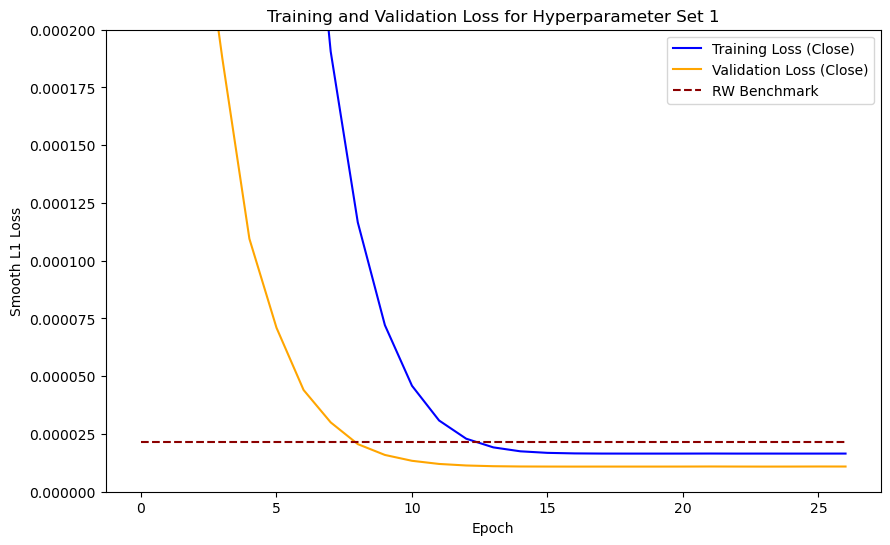

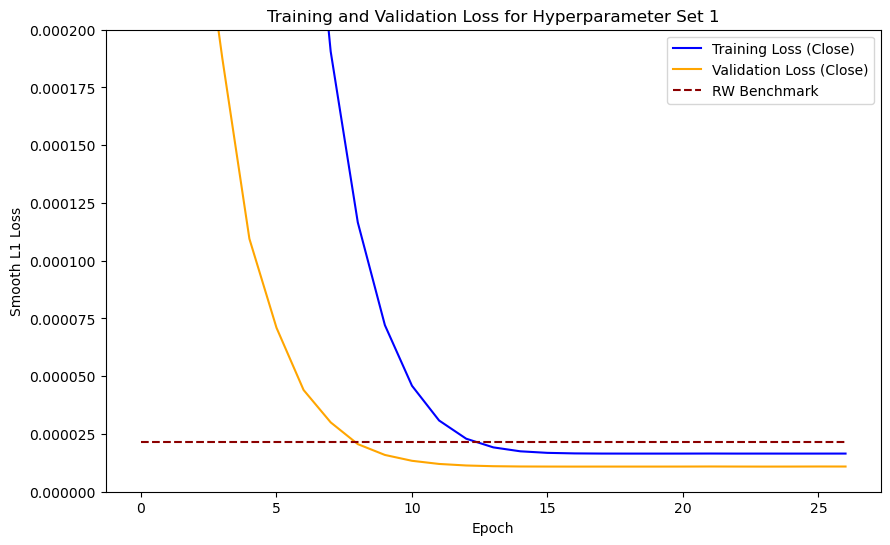

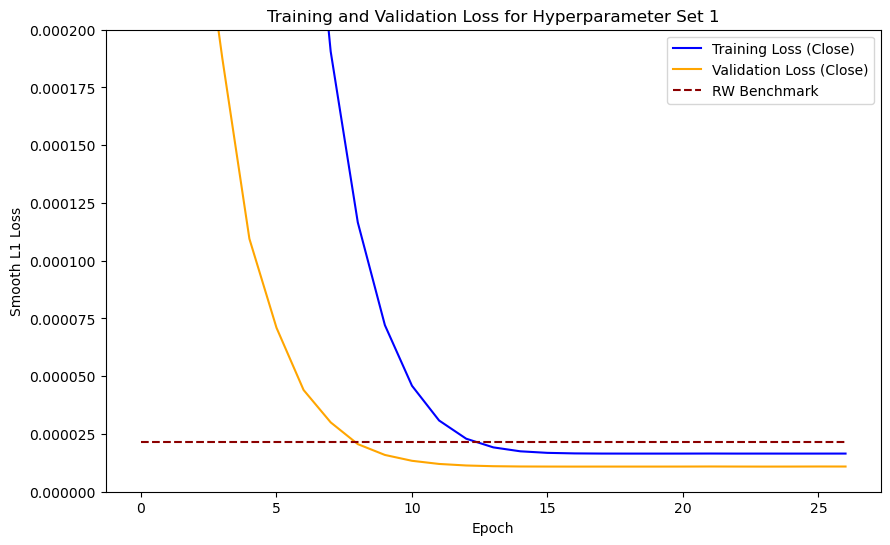

In [33]:
# Plot Performance for Each Hyperparameter Set
ylim_max = 0.0002

for config_idx, loss_config in enumerate(loss_configs):  # Loop over the 6 hyperparameter alternatives
    alt = 0
    train_losses_close = train_losses_close_master[alt]
    val_losses_close = val_losses_close_master[alt]

    # Create RW Benchmark Line for Validation Loss
    RW_benchmark_MSE_valid = model_accuracy_table_RW_valid['MSE'][0]  # Fixed RW Benchmark value
    RW_benchmark_MSE_line = np.full(len(train_losses_close), RW_benchmark_MSE_valid)  # Benchmark line

    # Plot losses and benchmark
    plt.figure(figsize=(10, 6))
    plt.plot(train_losses_close, label='Training Loss (Close)', color='blue')
    plt.plot(val_losses_close, label='Validation Loss (Close)', color='orange')
    plt.plot(RW_benchmark_MSE_line, label='RW Benchmark', color='darkred', linestyle='--')
    
    # Formatting
    plt.title(f"Training and Validation Loss for Hyperparameter Set {alt+1}")
    plt.xlabel("Epoch")
    plt.ylabel("Smooth L1 Loss")
    plt.legend()
    plt.ylim([0, ylim_max])  # Adjust based on your loss range
    plt.grid(False)
    plt.show()

In [34]:
# Directory to store the results
results_dir = "results_table"

# Create the directory if it does not exist
if not os.path.exists(results_dir):
    os.makedirs(results_dir)

for i, result in enumerate(hyperparameter_results):
    print(f"\nCalculating metrics for Hyperparameter Set {i+1}...")
    
    model = LSTMModel(
        input_dim=input_dim,
        hidden_dim=result["hidden_dim"],
        output_dim=output_dim,
        num_layers=result["num_layers"],
        dropout_rate=result["dropout_rate"]
    ).to(device)

    model.load_state_dict(result["best_model_state"])

    print(f"Loaded the best model with Hidden Dim: {result['hidden_dim']}, "
          f"Num Layers: {result['num_layers']}, "
          f"Batch Size: {result['batch_size']}, "
          f"Validation Loss (Close): {result['best_val_loss_close']:.10f}, "
          f"loss_config: {result['loss_config']}")

    batch_size_predictions = 50

    # Function to make predictions in batches
    def predict_in_batches(model, data, batch_size):
        model.eval()
        predictions = []
        with torch.no_grad():
            for i in range(0, len(data), batch_size):
                batch_data = data[i:i + batch_size].to(device)
                batch_predictions = model(batch_data).cpu().numpy()
                predictions.append(batch_predictions)
                if i % 1000 == 0:
                    print(f"Iteration: {i} / {len(data)}")
        return np.concatenate(predictions, axis=0)

    # Make predictions in batches
    train_predictions = predict_in_batches(model, X_train, batch_size_predictions)
    valid_predictions = predict_in_batches(model, X_valid, batch_size_predictions)
    test_predictions = predict_in_batches(model, X_test, batch_size_predictions)

    # Focus only on 'close' price (index 3)
    train_predictions_close_percent = train_predictions[:, :, 3]
    valid_predictions_close_percent = valid_predictions[:, :, 3]
    test_predictions_close_percent = test_predictions[:, :, 3]
    
    train_predictions_close_prices = np.full((train_predictions_close_percent.shape[0],forecast_horizon),np.nan)
    valid_predictions_close_prices = np.full((valid_predictions_close_percent.shape[0],forecast_horizon),np.nan)
    test_predictions_close_prices = np.full((test_predictions_close_percent.shape[0],forecast_horizon),np.nan)

    #### Creating Model Accuracy Metrics for Comparison to Random Walk Benchmark
    train_actuals_close_prices = y_train_prices[:,:,3]
    valid_actuals_close_prices = y_valid_prices[:,:,3]
    test_actuals_close_prices = y_test_prices[:,:,3]
    
    n_cols = X_train_prices.shape[1]

    for h in range(forecast_horizon):
        if h == 0:
            train_predictions_close_prices[:,h] = X_train_prices[:,(n_cols-1),3] * (1 + train_predictions_close_percent[:,h])
            valid_predictions_close_prices[:,h] = X_valid_prices[:,(n_cols-1),3] * (1 + valid_predictions_close_percent[:,h])
            test_predictions_close_prices[:,h] = X_test_prices[:,(n_cols-1),3] * (1 + test_predictions_close_percent[:,h])
        else:
            train_predictions_close_prices[:,h] = train_predictions_close_prices[:,h-1] * (1 + train_predictions_close_percent[:,h]) 
            valid_predictions_close_prices[:,h] = valid_predictions_close_prices[:,h-1] * (1 + valid_predictions_close_percent[:,h])
            test_predictions_close_prices[:,h] = test_predictions_close_prices[:,h-1] * (1 + test_predictions_close_percent[:,h])


    # Calculating Primary Accuracy Metrics
    model_accuracy_table_train = create_basic_accuracy_table(predictions = train_predictions_close_prices,
                                                                  actuals = train_actuals_close_prices)
    
    model_accuracy_table_valid = create_basic_accuracy_table(predictions = valid_predictions_close_prices,
                                                                  actuals = valid_actuals_close_prices)
    
    model_accuracy_table_test = create_basic_accuracy_table(predictions = test_predictions_close_prices,
                                                                  actuals = test_actuals_close_prices)

    
    # Adding Directional Accuracy
    model_accuracy_table_train = add_directional_accuracy(accuracy_table = model_accuracy_table_train,
                                                         inputs_actuals = X_train_prices, 
                                                         predictions = train_predictions_close_prices, 
                                                         targets = train_actuals_close_prices)
    
    model_accuracy_table_valid = add_directional_accuracy(accuracy_table = model_accuracy_table_valid,
                                                         inputs_actuals = X_valid_prices, 
                                                         predictions = valid_predictions_close_prices, 
                                                         targets = valid_actuals_close_prices)
    
    model_accuracy_table_test = add_directional_accuracy(accuracy_table = model_accuracy_table_test,
                                                         inputs_actuals = X_test_prices, 
                                                         predictions = test_predictions_close_prices, 
                                                         targets = test_actuals_close_prices)

    pd.set_option('display.max_columns', None) 
    pd.set_option('display.width', 200)        
    pd.set_option('display.max_rows', None)

    print(model_accuracy_table_train)
    print(model_accuracy_table_valid)
    print(model_accuracy_table_test)

    # Save results for this hyperparameter setting
    setting_dir = os.path.join(results_dir, f"Sentiment_Setting_Run_2_{i+1}")
    if not os.path.exists(setting_dir):
        os.makedirs(setting_dir)

    # Save parameters as a text file
    with open(os.path.join(setting_dir, "parameters.txt"), "w") as f:
        f.write(f"Hidden Dim: {result['hidden_dim']}\n")
        f.write(f"Num Layers: {result['num_layers']}\n")
        f.write(f"Batch Size: {result['batch_size']}\n")
        f.write(f"Validation Loss (Close): {result['best_val_loss_close']:.10f}\n")
        f.write(f"Loss Config: {result['loss_config']}\n")

    # Save accuracy tables as CSV files
    model_accuracy_table_train.to_csv(os.path.join(setting_dir, "accuracy_table_train.csv"), index=False)
    model_accuracy_table_valid.to_csv(os.path.join(setting_dir, "accuracy_table_valid.csv"), index=False)
    model_accuracy_table_test.to_csv(os.path.join(setting_dir, "accuracy_table_test.csv"), index=False)

    print(f"Results saved for Setting {i+1} in {setting_dir}")


Calculating metrics for Hyperparameter Set 1...
Loaded the best model with Hidden Dim: 20, Num Layers: 1, Batch Size: 128, Validation Loss (Close): 0.0000108749, loss_config: {'gamma': 1, 'beta': 1, 'beta_v': 1, 'alpha': 0.1, 'lambda_v': 0, 'lambda_dir': 0}
Iteration: 0 / 71586
Iteration: 1000 / 71586
Iteration: 2000 / 71586
Iteration: 3000 / 71586
Iteration: 4000 / 71586
Iteration: 5000 / 71586
Iteration: 6000 / 71586
Iteration: 7000 / 71586
Iteration: 8000 / 71586
Iteration: 9000 / 71586
Iteration: 10000 / 71586
Iteration: 11000 / 71586
Iteration: 12000 / 71586
Iteration: 13000 / 71586
Iteration: 14000 / 71586
Iteration: 15000 / 71586
Iteration: 16000 / 71586
Iteration: 17000 / 71586
Iteration: 18000 / 71586
Iteration: 19000 / 71586
Iteration: 20000 / 71586
Iteration: 21000 / 71586
Iteration: 22000 / 71586
Iteration: 23000 / 71586
Iteration: 24000 / 71586
Iteration: 25000 / 71586
Iteration: 26000 / 71586
Iteration: 27000 / 71586
Iteration: 28000 / 71586
Iteration: 29000 / 71586
Iter

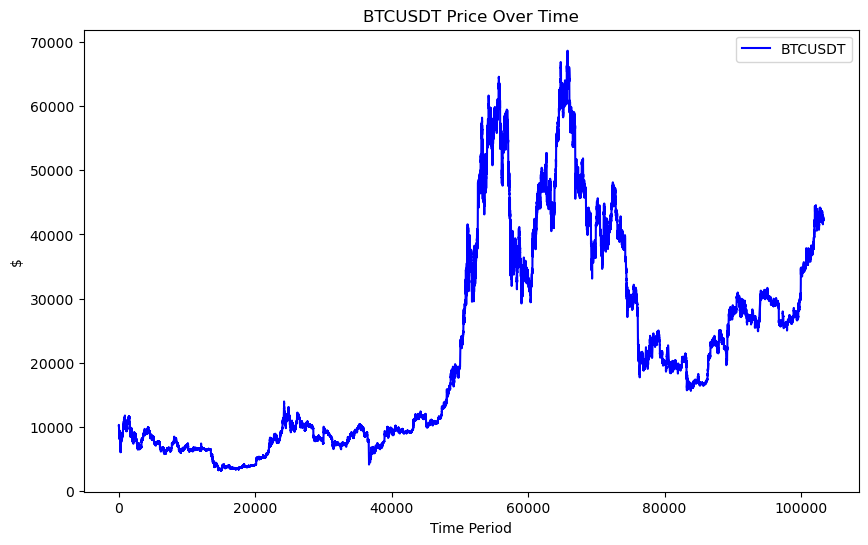

In [35]:
device = torch.device("mps" if torch.backends.mps.is_built() else "cpu")
random.seed(150)
torch.cuda.empty_cache()

plt.figure(figsize=(10, 6))
plt.plot(btc_close, label="BTCUSDT", color="blue")
plt.xlabel("Time Period")
plt.ylabel("$")
plt.title("BTCUSDT Price Over Time")
plt.legend()
plt.grid(False)
plt.show()

In [36]:
# Set parameters
window_size = 1*24*2*20 # per-hour*hours-per-day*days
forecast_horizon = 1*24*2 # 1 day

variables = ['open_return', 'high_return', 'low_return', 'close_return','normalized_dollar_volume', 'fear_index_normalized']
variables_levels = ['open', 'high', 'low', 'close','normalized_dollar_volume', 'fear_index_normalized']
df_model = df[variables]
df_model_levels = df[variables_levels]
print("Getting X, y")
X, y = create_windowed_sequences(df_model, window_size, forecast_horizon = forecast_horizon)
print("Getting X_prices, y_prices")
X_prices, y_prices = create_windowed_sequences_levels(df_model_levels, window_size, forecast_horizon = forecast_horizon)

# Calculate exact split sizes
train_ratio, valid_ratio, test_ratio = 0.7, 0.15, 0.15
total_size = len(X)

# First, calculate training and validation sizes
train_size = int(total_size * train_ratio)
valid_size = int(total_size * valid_ratio)
test_size = total_size - (train_size + valid_size)  # Assign remaining data to test to ensure total matches

# Apply the split
X_train, y_train = X[:train_size], y[:train_size]
X_valid, y_valid = X[train_size:train_size + valid_size], y[train_size:train_size + valid_size]
X_test, y_test = X[train_size + valid_size:], y[train_size + valid_size:]

X_train_prices, y_train_prices = X_prices[:train_size], y_prices[:train_size]
X_valid_prices, y_valid_prices = X_prices[train_size:train_size + valid_size], y_prices[train_size:train_size + valid_size]
X_test_prices, y_test_prices = X_prices[train_size + valid_size:], y_prices[train_size + valid_size:]

forecast_matrix_RW_test, model_accuracy_table_RW_test = run_arima_windows_univariate(X_test[:,:,3],
                                                                              y_test[:,:,3],
                                                                              p=0, d=0, q=0,
                                                                              trend = None,
                                                                              horizon=forecast_horizon)
forecast_matrix_RW_valid, model_accuracy_table_RW_valid = run_arima_windows_univariate(X_valid[:,:,3],
                                                                              y_valid[:,:,3],
                                                                              p=0, d=0, q=0,
                                                                              trend = None,
                                                                              horizon=forecast_horizon)

print(model_accuracy_table_RW_test)
print(forecast_matrix_RW_test)

model_accuracy_table_RW_test.to_csv('model_accuracy_table_RW_test.csv', index=False)
np.save('forecast_matrix_RW_test.npy', forecast_matrix_RW_test)

model_accuracy_table_RW_test = pd.read_csv('model_accuracy_table_RW_test.csv', na_values=["inf", "NaN"])
forecast_matrix_RW_test = np.load('forecast_matrix_RW_test.npy')
print(model_accuracy_table_RW_test)
print(forecast_matrix_RW_test)

Getting X, y
Getting X_prices, y_prices
        RMSE      MSE        ME      MAPE       MPE       R^2
0   0.003211  0.00001 -0.000048  0.999472 -0.999472 -0.000227
1   0.003211  0.00001 -0.000049  0.999472 -0.999472 -0.000230
2   0.003211  0.00001 -0.000049  0.999472 -0.999472 -0.000230
3   0.003211  0.00001 -0.000048  0.999472 -0.999472 -0.000227
4   0.003211  0.00001 -0.000048  0.999472 -0.999472 -0.000225
5   0.003211  0.00001 -0.000048  0.999472 -0.999472 -0.000223
6   0.003211  0.00001 -0.000048  0.999472 -0.999472 -0.000223
7   0.003211  0.00001 -0.000048  0.999472 -0.999472 -0.000225
8   0.003211  0.00001 -0.000048  0.999472 -0.999472 -0.000226
9   0.003211  0.00001 -0.000048  0.999472 -0.999472 -0.000225
10  0.003211  0.00001 -0.000048  0.999472 -0.999472 -0.000224
11  0.003211  0.00001 -0.000048  0.999472 -0.999472 -0.000224
12  0.003211  0.00001 -0.000048  0.999472 -0.999472 -0.000228
13  0.003211  0.00001 -0.000049  0.999472 -0.999472 -0.000232
14  0.003202  0.00001 -0.00004

In [37]:
# Convert data to PyTorch tensors
X_train = torch.tensor(X_train, dtype=torch.float32).to(device)
y_train = torch.tensor(y_train, dtype=torch.float32).to(device)
X_valid = torch.tensor(X_valid, dtype=torch.float32).to(device)
y_valid = torch.tensor(y_valid, dtype=torch.float32).to(device)
X_test = torch.tensor(X_test, dtype=torch.float32).to(device)
y_test = torch.tensor(y_test, dtype=torch.float32).to(device)

# Hyperparameters
input_dim = 6
hidden_dim = 200
num_layers = 1
output_dim = forecast_horizon * 6
num_epochs = 100
batch_size = 20 # 32
learning_rate = 0.0001 # 0.001
dropout_rate = 0.2
patience = 5

# Initialize model, loss function, and optimizer
model = LSTMModel(input_dim, hidden_dim, output_dim, num_layers, dropout_rate).to(device)
criterion = nn.SmoothL1Loss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

# Prepare DataLoader for training
train_data = TensorDataset(X_train, y_train)
train_loader = DataLoader(train_data, shuffle=True, batch_size=batch_size)

# Training loop with early stopping
best_val_loss = float('inf')
epochs_no_improve = 0

In [38]:
class CombinedLoss(nn.Module):
    def __init__(self, gamma=0.9, beta=1.0, beta_v=1.0, alpha=0.1, lambda_d=1.0, lambda_v=1.0, lambda_dir=1.0):
        """
        Combined loss function with decoupled parameters for baseline and volatility losses.
        Args:
            gamma (float): Discount rate for near-term accuracy in DiscountedSmoothL1Loss.
            beta (float): Smooth L1 Loss transition point for baseline loss.
            beta_v (float): Smooth L1 Loss transition point for volatility loss.
            alpha (float): Weight for directional accuracy in DirectionalLoss.
            lambda_d (float): Weight for baseline loss (DiscountedSmoothL1Loss).
            lambda_v (float): Weight for volatility loss (decoupled volatility penalty).
            lambda_dir (float): Weight for directional accuracy loss (DirectionalLoss).
        """
        super(CombinedLoss, self).__init__()
        self.gamma = gamma
        self.beta = beta  # For baseline loss
        self.beta_v = beta_v  # For volatility loss
        self.alpha = alpha
        self.lambda_d = lambda_d
        self.lambda_v = lambda_v
        self.lambda_dir = lambda_dir

    def forward(self, predictions, targets, historical_prices):
        """
        Compute the combined loss.
        Args:
            predictions: Predicted values (e.g., future prices).
            targets: Actual future values (ground truth).
            historical_prices: Current prices (to determine volatility and directions).
        Returns:
            torch.Tensor: Combined loss.
        """
        horizon = predictions.size(1)  # Assumes shape (batch_size, horizon, ...)
        historical_prices = historical_prices.unsqueeze(1).expand_as(predictions)
        
        # -------------------------------
        # Baseline Loss: DiscountedSmoothL1Loss
        # -------------------------------
        diff = torch.abs(predictions - targets)

        # Smooth L1 Loss with quadratic behavior for small errors, linear for large errors
        base_loss = torch.where(
            diff < self.beta,  # Use baseline `beta`
            0.5 * (diff ** 2) / self.beta,
            diff - 0.5 * self.beta
        )

        # Apply discount factors
        discount_factors = torch.tensor([self.gamma ** (h - 1) for h in range(1, horizon + 1)], device=predictions.device)
        discount_factors = discount_factors.view(1, -1, *(1,) * (base_loss.ndim - 2))  # Broadcast
        discounted_loss = base_loss * discount_factors

        baseline_loss = discounted_loss.mean()  # Average over all dimensions

        # -------------------------------
        # Decoupled Volatility Loss
        # -------------------------------
        # Compute volatility as the absolute changes in predictions and targets
        predicted_changes = torch.abs(predictions - historical_prices)
        actual_changes = torch.abs(targets - historical_prices)

        # Compute mismatch in volatility
        volatility_diff = torch.abs(predicted_changes - actual_changes)

        # Smooth L1 behavior for volatility mismatch, using `beta_v`
        volatility_loss = torch.where(
            volatility_diff < self.beta_v,  # Use separate `beta_v` for volatility
            0.5 * (volatility_diff ** 2) / self.beta_v,
            volatility_diff - 0.5 * self.beta_v
        ).mean()

        # -------------------------------
        # Directional Accuracy Loss
        # -------------------------------
        # Compute directional accuracy
        predicted_directions = torch.sign(predictions - historical_prices)
        actual_directions = torch.sign(targets - historical_prices)
        directional_accuracy = (predicted_directions == actual_directions).float().mean()

        # Penalize incorrect directions
        directional_loss = self.alpha * (1 - directional_accuracy)

        # -------------------------------
        # Combined Loss
        # -------------------------------
        combined_loss = (
            self.lambda_d * baseline_loss +       # Baseline loss
            self.lambda_v * volatility_loss +    # Volatility mismatch penalty
            self.lambda_dir * directional_loss   # Directional accuracy penalty
        )

        return combined_loss

# Experiment with different loss configurations
loss_configs = [
    {"gamma": 1, "beta": 1, "beta_v": 1, "alpha": 0.1, "lambda_v": 0, "lambda_dir": 0},  # Basic Loss
    # {"gamma": 1, "beta": 1, "beta_v": 1.2, "alpha": 0.1, "lambda_v": 0.5, "lambda_dir": 0},
    # {"gamma": 1, "beta": 1, "beta_v": 1.5, "alpha": 0.1, "lambda_v": 1, "lambda_dir": 0},
    # {"gamma": 1, "beta": 1, "beta_v": 2, "alpha": 0.1, "lambda_v": 1.5, "lambda_dir": 0},
    {"gamma": 1, "beta": 1, "beta_v": 1, "alpha": 1.2, "lambda_v": 0, "lambda_dir": 0.5},
    {"gamma": 1, "beta": 1, "beta_v": 1, "alpha": 1.5, "lambda_v": 0, "lambda_dir": 1},
    # {"gamma": 1, "beta": 1, "beta_v": 1, "alpha": 2, "lambda_v": 0, "lambda_dir": 1.5},
    # {"gamma": 1, "beta": 1, "beta_v": 1.2, "alpha": 1.2, "lambda_v": 0.5, "lambda_dir": 0.5},
    # {"gamma": 1, "beta": 1, "beta_v": 1.2, "alpha": 1.5, "lambda_v": 1, "lambda_dir": 1},
    # {"gamma": 1, "beta": 1, "beta_v": 1.5, "alpha": 1.2, "lambda_v": 1, "lambda_dir": 1},
    # {"gamma": 1, "beta": 1, "beta_v": 2, "alpha": 2, "lambda_v": 1.5, "lambda_dir": 1.5},
]

# Training loop with early stopping
best_val_loss = float('inf')
epochs_no_improve = 0

# Hyperparameters
input_dim = 6 #<--- Dont change this
# hidden_dim = [20, 20, 20, 50, 50, 50, 50, 50, 50] # round 1
hidden_dim = [20] # best round 1
# hidden_dim = [64, 64, 64, 128, 128, 128, 256, 256, 256, 512, 512, 512] # round 2
# hidden_dim = [64] # best round 2
# num_layers = [1, 1, 1, 1, 1, 1, 2, 2, 2] # round 1
num_layers = [1] # best round 1
# num_layers = [1, 1, 2, 1, 1, 2, 1, 1, 2, 1, 1, 2] # round 2
# num_layers = [1] # best round 2
output_dim = forecast_horizon * 6 #<--- Dont change this
num_epochs = 100 #<--- Dont change this
# batch_size = [128, 128, 128, 128, 128, 128, 128, 128, 128] # round 1
batch_size = [128] # best round 1
# batch_size = [64, 64, 128, 64, 64, 128, 64, 64, 128, 64, 64, 128] # round 2
# batch_size = [64] # best round 2
learning_rate = 0.0001 # 0.001
# dropout_rate = [0.2, 0.2, 0.2, 0.3, 0.3, 0.3, 0.3, 0.3, 0.3] # round 1
dropout_rate = [0.2] # best round 1
# dropout_rate = [0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2] # round 2
# dropout_rate = [0.2] # best round 2
patience = 10 #<--- Dont change this
# GAMMA = [1, 0.8, 0.65, 1, 0.8, 0.65, 1, 0.8, 0.65] # round 1
# GAMMA = [1] # best round 1
# GAMMA = [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1] # round 2
# GAMMA = [1] # best round 2

n_alternatives = len(hidden_dim)

train_losses_master = []
train_losses_close_master = []
val_losses_master = []
val_losses_close_master = []
best_model_state_master = []
best_model_state_close_master = []
hyperparameter_results = []

    
for config_idx, loss_config in enumerate(loss_configs):
    alt = 0
    print(f"Running Configuration {config_idx + 1}: {loss_config}")
    
    # Initialize model, loss function, and optimizer
    model = LSTMModel(input_dim, hidden_dim[alt], output_dim, num_layers[alt], dropout_rate[alt]).to(device)
    training_criterion = CombinedLoss(
        gamma=loss_config["gamma"],
        beta=loss_config["beta"],
        beta_v=loss_config["beta_v"],
        alpha=loss_config["alpha"],
        lambda_v=loss_config["lambda_v"],
        lambda_dir=loss_config["lambda_dir"]
    )
    valid_criterion = nn.SmoothL1Loss()
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

    # Prepare DataLoader for training
    train_data = TensorDataset(X_train, y_train)
    train_loader = DataLoader(train_data, shuffle=True, batch_size=batch_size[alt])
    
    val_data = TensorDataset(X_valid, y_valid)   #
    val_loader = DataLoader(val_data, shuffle=False, batch_size=batch_size[alt], )  #

    # Training loop with early stopping
    best_val_loss = float('inf')
    best_val_loss_close = float('inf')
    epochs_no_improve = 0

    # Create Lists to Track Error Across Epochs
    train_losses = []
    train_losses_close = []
    val_losses = []
    val_losses_close = []


    for epoch in range(num_epochs):
        model.train()
        epoch_train_loss = 0
        epoch_train_loss_close = 0

        for inputs, targets in train_loader:
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = model(inputs)
            loss = training_criterion(outputs, targets, inputs[:, -1, :])
            loss_close = valid_criterion(outputs[:,:,3], targets[:,:,3]) # Not a typo - I want comparable training loss and its only the gradient descent I want the discounted criterion
            epoch_train_loss += loss.item()
            epoch_train_loss_close += loss_close.item()

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

        avg_train_loss = epoch_train_loss / len(train_loader)
        train_losses.append(avg_train_loss)
        avg_train_loss_close = epoch_train_loss_close / len(train_loader)
        train_losses_close.append(avg_train_loss_close)

        # Validation Loss
        model.eval()
        epoch_val_loss = 0
        epoch_val_loss_close = 0
        with torch.no_grad():
            for val_inputs, val_targets in val_loader:
                
                val_inputs, val_targets = val_inputs.to(device), val_targets.to(device)
                val_outputs = model(val_inputs)
                val_loss = valid_criterion(val_outputs, val_targets)
                val_loss_close = valid_criterion(val_outputs[:,:,3], val_targets[:,:,3])
                epoch_val_loss += val_loss.item()
                epoch_val_loss_close += val_loss_close.item()
                
                #val_outputs = model(X_valid.to(device))
                #val_loss = criterion(val_outputs, y_valid.to(device))
                #val_losses.append(val_loss.item())
                #val_loss_close = criterion(val_outputs[:,:,3], y_valid[:,:,3].to(device))
                #val_losses_close.append(val_loss_close.item())
                
        avg_val_loss = epoch_val_loss / len(val_loader)
        val_losses.append(avg_val_loss)
        avg_val_loss_close = epoch_val_loss_close / len(val_loader)
        val_losses_close.append(avg_val_loss_close)


        print(f"Epoch [{epoch+1}/{num_epochs}], "
          f"Training Loss: {avg_train_loss:.10f}, "
          f"Validation Loss: {avg_val_loss:.10f}, "
          #f"Training Loss (Close): {avg_train_loss_close:.10f}, "
          f"Validation Loss (Close): {avg_val_loss_close:.10f}")


        # Check for improvement
        if avg_val_loss < best_val_loss:
            best_val_loss = avg_val_loss
            epochs_no_improve = 0
            best_model_state = model.state_dict()
        else:
            epochs_no_improve += 1
            
        if avg_val_loss_close < best_val_loss_close:
            best_val_loss_close = avg_val_loss_close
            epochs_no_improve_close = 0
            best_model_state_close = model.state_dict()
        else:
            epochs_no_improve_close += 1

        #if epochs_no_improve >= patience:
        #    print(f"Early stopping triggered after {epoch+1} epochs.")
        #    break
            
        if epochs_no_improve_close >= patience:
            print(f"Early stopping triggered after {epoch+1} epochs (Based on Closing Price Returns).")
            break
            
    train_losses_master.append(train_losses)
    train_losses_close_master.append(train_losses_close)
    val_losses_master.append(val_losses)
    val_losses_close_master.append(val_losses_close)
    best_model_state_master.append(best_model_state.copy())
    
    result = {
        "hidden_dim": hidden_dim[alt],
        "num_layers": num_layers[alt],
        "batch_size": batch_size[alt],
        "dropout_rate": dropout_rate[alt],
        "best_val_loss": best_val_loss,
        "best_val_loss_close": best_val_loss_close,
        "train_losses": train_losses,
        "val_losses": val_losses,
        "train_losses_close": train_losses_close,
        "val_losses_close": val_losses_close,
        "best_model_state": best_model_state,
        "best_model_state_close": best_model_state_close,
        "loss_config": loss_config
    }
    hyperparameter_results.append(result)

Running Configuration 1: {'gamma': 1, 'beta': 1, 'beta_v': 1, 'alpha': 0.1, 'lambda_v': 0, 'lambda_dir': 0}
Epoch [1/100], Training Loss: 0.1010561486, Validation Loss: 0.0570825785, Validation Loss (Close): 0.0003587773
Epoch [2/100], Training Loss: 0.0543289303, Validation Loss: 0.0454487725, Validation Loss (Close): 0.0004865151
Epoch [3/100], Training Loss: 0.0476914485, Validation Loss: 0.0441788523, Validation Loss (Close): 0.0003853251
Epoch [4/100], Training Loss: 0.0453962647, Validation Loss: 0.0427892821, Validation Loss (Close): 0.0002596948
Epoch [5/100], Training Loss: 0.0437070418, Validation Loss: 0.0406428687, Validation Loss (Close): 0.0001536615
Epoch [6/100], Training Loss: 0.0421811526, Validation Loss: 0.0386650472, Validation Loss (Close): 0.0000936337
Epoch [7/100], Training Loss: 0.0413140336, Validation Loss: 0.0377722710, Validation Loss (Close): 0.0000609577
Epoch [8/100], Training Loss: 0.0407523734, Validation Loss: 0.0375524013, Validation Loss (Close): 0

In [39]:
save_dir = "../results/"

# Save metadata
results_metadata = [
    {
        "hidden_dim": result["hidden_dim"],
        "num_layers": result["num_layers"],
        "batch_size": result["batch_size"],
        "dropout_rate": result["dropout_rate"],
        "best_val_loss": result["best_val_loss"],
        "best_val_loss_close": result["best_val_loss_close"],
        "loss_config": result["loss_config"]
    }
    for result in hyperparameter_results
]

metadata_path = os.path.join(save_dir, "results_metadata.json")
with open(metadata_path, "w") as f:
    json.dump(results_metadata, f, indent=4)

# Save each model state
for i, result in enumerate(hyperparameter_results):
    model_path = os.path.join(save_dir, f"best_model_state_BTCUSDT_sentiment_third_run_{i}.pth")
    torch.save(result["best_model_state"], model_path)

print(f"Metadata saved to {metadata_path}. Model states saved to {save_dir}.")

# Load Hyper Parameter Results
with open(metadata_path, "r") as f:
    loaded_metadata = json.load(f)

# Reload models
loaded_results = []
for i, meta in enumerate(loaded_metadata):
    model_path = os.path.join(save_dir, f"best_model_state_BTCUSDT_sentiment_third_run_{i}.pth")
    model_state = torch.load(model_path, weights_only=True)

    result = {
        "hidden_dim": meta["hidden_dim"],
        "num_layers": meta["num_layers"],
        "batch_size": meta["batch_size"],
        "dropout_rate": meta["dropout_rate"],
        "best_val_loss": meta["best_val_loss"],
        "best_val_loss_close": meta["best_val_loss_close"],
        "loss_config": meta["loss_config"],
        "best_model_state": model_state
    }
    loaded_results.append(result)

print("Results reloaded successfully!")

Metadata saved to ../results/results_metadata.json. Model states saved to ../results/.
Results reloaded successfully!


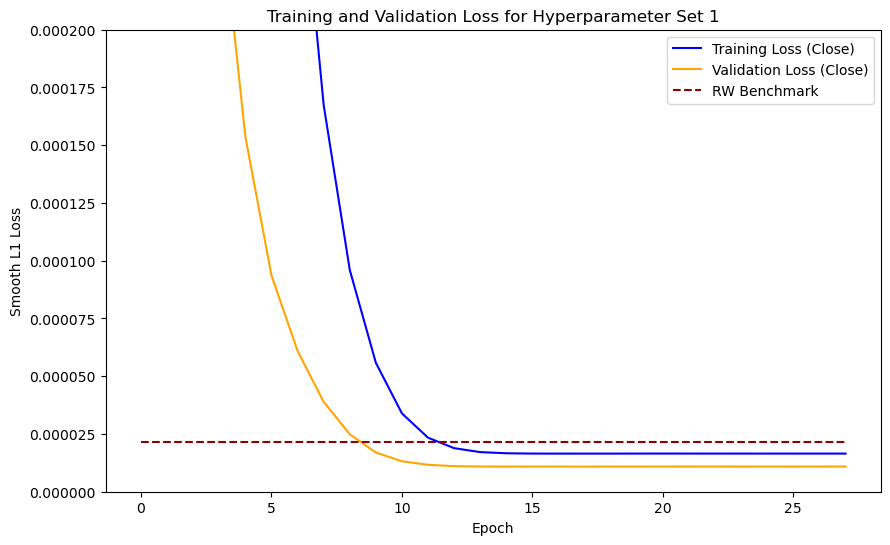

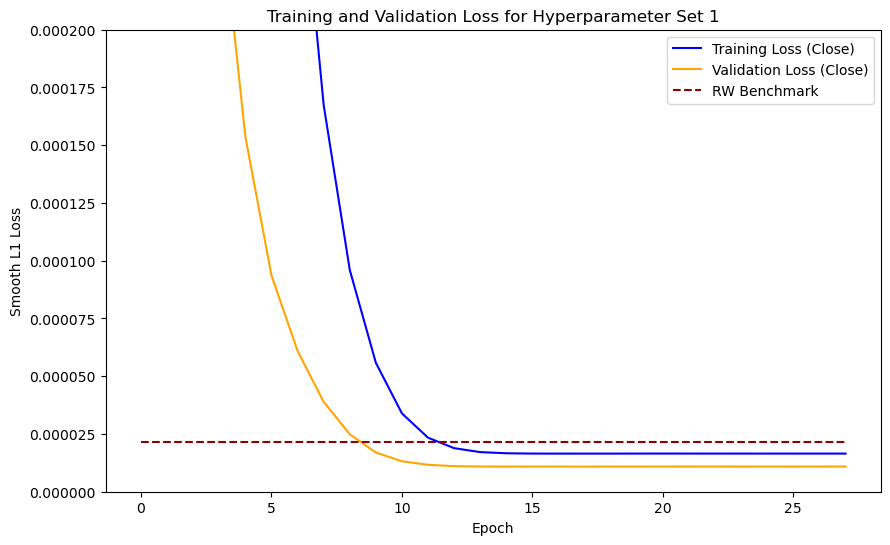

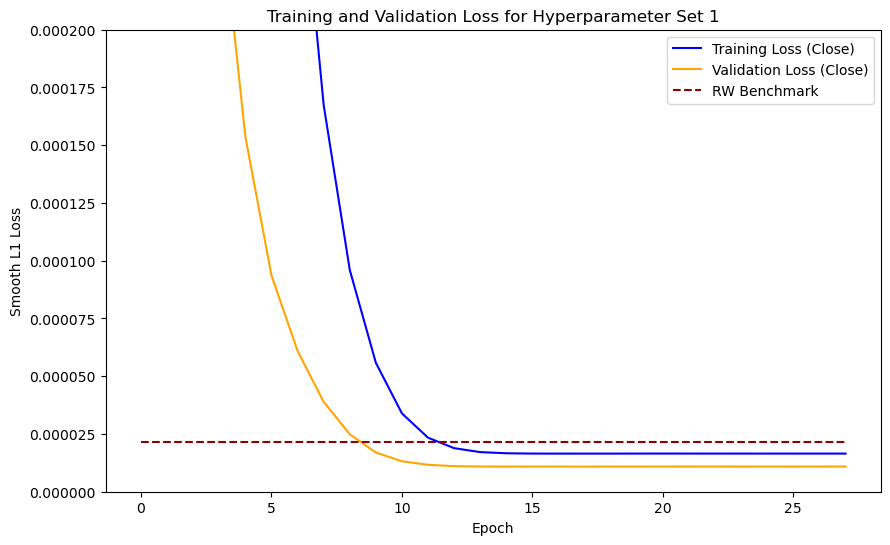

In [40]:
# Plot Performance for Each Hyperparameter Set
ylim_max = 0.0002

for config_idx, loss_config in enumerate(loss_configs):  # Loop over the 6 hyperparameter alternatives
    alt = 0
    train_losses_close = train_losses_close_master[alt]
    val_losses_close = val_losses_close_master[alt]

    # Create RW Benchmark Line for Validation Loss
    RW_benchmark_MSE_valid = model_accuracy_table_RW_valid['MSE'][0]  # Fixed RW Benchmark value
    RW_benchmark_MSE_line = np.full(len(train_losses_close), RW_benchmark_MSE_valid)  # Benchmark line

    # Plot losses and benchmark
    plt.figure(figsize=(10, 6))
    plt.plot(train_losses_close, label='Training Loss (Close)', color='blue')
    plt.plot(val_losses_close, label='Validation Loss (Close)', color='orange')
    plt.plot(RW_benchmark_MSE_line, label='RW Benchmark', color='darkred', linestyle='--')
    
    # Formatting
    plt.title(f"Training and Validation Loss for Hyperparameter Set {alt+1}")
    plt.xlabel("Epoch")
    plt.ylabel("Smooth L1 Loss")
    plt.legend()
    plt.ylim([0, ylim_max])  # Adjust based on your loss range
    plt.grid(False)
    plt.show()

In [41]:
# Directory to store the results
results_dir = "results_table"

# Create the directory if it does not exist
if not os.path.exists(results_dir):
    os.makedirs(results_dir)

for i, result in enumerate(hyperparameter_results):
    print(f"\nCalculating metrics for Hyperparameter Set {i+1}...")
    
    model = LSTMModel(
        input_dim=input_dim,
        hidden_dim=result["hidden_dim"],
        output_dim=output_dim,
        num_layers=result["num_layers"],
        dropout_rate=result["dropout_rate"]
    ).to(device)

    model.load_state_dict(result["best_model_state"])

    print(f"Loaded the best model with Hidden Dim: {result['hidden_dim']}, "
          f"Num Layers: {result['num_layers']}, "
          f"Batch Size: {result['batch_size']}, "
          f"Validation Loss (Close): {result['best_val_loss_close']:.10f}, "
          f"loss_config: {result['loss_config']}")

    batch_size_predictions = 50

    # Function to make predictions in batches
    def predict_in_batches(model, data, batch_size):
        model.eval()
        predictions = []
        with torch.no_grad():
            for i in range(0, len(data), batch_size):
                batch_data = data[i:i + batch_size].to(device)
                batch_predictions = model(batch_data).cpu().numpy()
                predictions.append(batch_predictions)
                if i % 1000 == 0:
                    print(f"Iteration: {i} / {len(data)}")
        return np.concatenate(predictions, axis=0)

    # Make predictions in batches
    train_predictions = predict_in_batches(model, X_train, batch_size_predictions)
    valid_predictions = predict_in_batches(model, X_valid, batch_size_predictions)
    test_predictions = predict_in_batches(model, X_test, batch_size_predictions)

    # Focus only on 'close' price (index 3)
    train_predictions_close_percent = train_predictions[:, :, 3]
    valid_predictions_close_percent = valid_predictions[:, :, 3]
    test_predictions_close_percent = test_predictions[:, :, 3]
    
    train_predictions_close_prices = np.full((train_predictions_close_percent.shape[0],forecast_horizon),np.nan)
    valid_predictions_close_prices = np.full((valid_predictions_close_percent.shape[0],forecast_horizon),np.nan)
    test_predictions_close_prices = np.full((test_predictions_close_percent.shape[0],forecast_horizon),np.nan)

    #### Creating Model Accuracy Metrics for Comparison to Random Walk Benchmark
    train_actuals_close_prices = y_train_prices[:,:,3]
    valid_actuals_close_prices = y_valid_prices[:,:,3]
    test_actuals_close_prices = y_test_prices[:,:,3]
    
    n_cols = X_train_prices.shape[1]

    for h in range(forecast_horizon):
        if h == 0:
            train_predictions_close_prices[:,h] = X_train_prices[:,(n_cols-1),3] * (1 + train_predictions_close_percent[:,h])
            valid_predictions_close_prices[:,h] = X_valid_prices[:,(n_cols-1),3] * (1 + valid_predictions_close_percent[:,h])
            test_predictions_close_prices[:,h] = X_test_prices[:,(n_cols-1),3] * (1 + test_predictions_close_percent[:,h])
        else:
            train_predictions_close_prices[:,h] = train_predictions_close_prices[:,h-1] * (1 + train_predictions_close_percent[:,h]) 
            valid_predictions_close_prices[:,h] = valid_predictions_close_prices[:,h-1] * (1 + valid_predictions_close_percent[:,h])
            test_predictions_close_prices[:,h] = test_predictions_close_prices[:,h-1] * (1 + test_predictions_close_percent[:,h])


    # Calculating Primary Accuracy Metrics
    model_accuracy_table_train = create_basic_accuracy_table(predictions = train_predictions_close_prices,
                                                                  actuals = train_actuals_close_prices)
    
    model_accuracy_table_valid = create_basic_accuracy_table(predictions = valid_predictions_close_prices,
                                                                  actuals = valid_actuals_close_prices)
    
    model_accuracy_table_test = create_basic_accuracy_table(predictions = test_predictions_close_prices,
                                                                  actuals = test_actuals_close_prices)

    
    # Adding Directional Accuracy
    model_accuracy_table_train = add_directional_accuracy(accuracy_table = model_accuracy_table_train,
                                                         inputs_actuals = X_train_prices, 
                                                         predictions = train_predictions_close_prices, 
                                                         targets = train_actuals_close_prices)
    
    model_accuracy_table_valid = add_directional_accuracy(accuracy_table = model_accuracy_table_valid,
                                                         inputs_actuals = X_valid_prices, 
                                                         predictions = valid_predictions_close_prices, 
                                                         targets = valid_actuals_close_prices)
    
    model_accuracy_table_test = add_directional_accuracy(accuracy_table = model_accuracy_table_test,
                                                         inputs_actuals = X_test_prices, 
                                                         predictions = test_predictions_close_prices, 
                                                         targets = test_actuals_close_prices)

    pd.set_option('display.max_columns', None) 
    pd.set_option('display.width', 200)        
    pd.set_option('display.max_rows', None)

    print(model_accuracy_table_train)
    print(model_accuracy_table_valid)
    print(model_accuracy_table_test)

    # Save results for this hyperparameter setting
    setting_dir = os.path.join(results_dir, f"Sentiment_Setting_Run_3_{i+1}")
    if not os.path.exists(setting_dir):
        os.makedirs(setting_dir)

    # Save parameters as a text file
    with open(os.path.join(setting_dir, "parameters.txt"), "w") as f:
        f.write(f"Hidden Dim: {result['hidden_dim']}\n")
        f.write(f"Num Layers: {result['num_layers']}\n")
        f.write(f"Batch Size: {result['batch_size']}\n")
        f.write(f"Validation Loss (Close): {result['best_val_loss_close']:.10f}\n")
        f.write(f"Loss Config: {result['loss_config']}\n")

    # Save accuracy tables as CSV files
    model_accuracy_table_train.to_csv(os.path.join(setting_dir, "accuracy_table_train.csv"), index=False)
    model_accuracy_table_valid.to_csv(os.path.join(setting_dir, "accuracy_table_valid.csv"), index=False)
    model_accuracy_table_test.to_csv(os.path.join(setting_dir, "accuracy_table_test.csv"), index=False)

    print(f"Results saved for Setting {i+1} in {setting_dir}")


Calculating metrics for Hyperparameter Set 1...
Loaded the best model with Hidden Dim: 20, Num Layers: 1, Batch Size: 128, Validation Loss (Close): 0.0000108649, loss_config: {'gamma': 1, 'beta': 1, 'beta_v': 1, 'alpha': 0.1, 'lambda_v': 0, 'lambda_dir': 0}
Iteration: 0 / 71586
Iteration: 1000 / 71586
Iteration: 2000 / 71586
Iteration: 3000 / 71586
Iteration: 4000 / 71586
Iteration: 5000 / 71586
Iteration: 6000 / 71586
Iteration: 7000 / 71586
Iteration: 8000 / 71586
Iteration: 9000 / 71586
Iteration: 10000 / 71586
Iteration: 11000 / 71586
Iteration: 12000 / 71586
Iteration: 13000 / 71586
Iteration: 14000 / 71586
Iteration: 15000 / 71586
Iteration: 16000 / 71586
Iteration: 17000 / 71586
Iteration: 18000 / 71586
Iteration: 19000 / 71586
Iteration: 20000 / 71586
Iteration: 21000 / 71586
Iteration: 22000 / 71586
Iteration: 23000 / 71586
Iteration: 24000 / 71586
Iteration: 25000 / 71586
Iteration: 26000 / 71586
Iteration: 27000 / 71586
Iteration: 28000 / 71586
Iteration: 29000 / 71586
Iter

In [42]:
results_dir = "results_table"

directional_accuracies = {}

for param_set in range(1, 4):
    param_set_key = f"Sentiment_Setting_{param_set}"
    runs = []
    
    # Run 1: Setting_X
    run_1_path = os.path.join(results_dir, param_set_key, "accuracy_table_test.csv")
    if os.path.exists(run_1_path):
        df = pd.read_csv(run_1_path)
        if "Direct. Acc." in df.columns:
            runs.append(df["Direct. Acc."].values)
        else:
            print(f"Column 'Direct. Acc.' not found in {run_1_path}")
    else:
        print(f"File not found: {run_1_path}")
    
    # Run 2: Setting_Run_2_X
    run_2_key = f"Sentiment_Setting_Run_2_{param_set}"
    run_2_path = os.path.join(results_dir, run_2_key, "accuracy_table_test.csv")
    if os.path.exists(run_2_path):
        df = pd.read_csv(run_2_path)
        if "Direct. Acc." in df.columns:
            runs.append(df["Direct. Acc."].values)
        else:
            print(f"Column 'Direct. Acc.' not found in {run_2_path}")
    else:
        print(f"File not found: {run_2_path}")
    
    # Run 3: Setting_Run_3_X
    run_3_key = f"Sentiment_Setting_Run_3_{param_set}"
    run_3_path = os.path.join(results_dir, run_3_key, "accuracy_table_test.csv")
    if os.path.exists(run_3_path):
        df = pd.read_csv(run_3_path)
        if "Direct. Acc." in df.columns:
            runs.append(df["Direct. Acc."].values)
        else:
            print(f"Column 'Direct. Acc.' not found in {run_3_path}")
    else:
        print(f"File not found: {run_3_path}")
    
    # Average the directional accuracy across all runs for this parameter set
    if runs:
        avg_directional_accuracy = sum(runs) / len(runs)  # Element-wise average
        directional_accuracies[param_set_key] = avg_directional_accuracy

# Convert the results into a DataFrame for better visualization
result_df = pd.DataFrame.from_dict(directional_accuracies, orient="index").transpose()

print(result_df)

    Sentiment_Setting_1  Sentiment_Setting_2  Sentiment_Setting_3
0              0.499294             0.500141             0.496534
1              0.496925             0.502683             0.500228
2              0.501054             0.500837             0.500445
3              0.498533             0.501793             0.499902
4              0.503748             0.501597             0.500598
5              0.501097             0.495817             0.503053
6              0.498425             0.501488             0.499620
7              0.497534             0.499641             0.499902
8              0.500728             0.503009             0.501358
9              0.498338             0.501249             0.499902
10             0.502749             0.499707             0.501401
11             0.503661             0.496447             0.499316
12             0.496882             0.501097             0.500706
13             0.501640             0.503661             0.501315
14        

In [43]:
# Calculate the average for each setting
averages = result_df.mean(axis=0).reset_index()
averages.columns = ['Setting', 'Average']

# Print the resulting DataFrame
print(averages)

               Setting   Average
0  Sentiment_Setting_1  0.500307
1  Sentiment_Setting_2  0.500192
2  Sentiment_Setting_3  0.500661
